In [5]:
#documentation:   https://pytorch.org/docs/stable/index.html
#                 https://pytorch.org/tutorials/

#must have the ml-20m folder with the movie lens data in the same directory as this ipnb for the fine tuner to runner

import fine_tuner as ft
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score


In [6]:
# Load the MovieLens dataset.  The fine tuner will make use of tags, movie titles, and the ratings
f1=pd.read_csv('ml-20m//movies.csv',sep=',',header=0)
f2=pd.read_csv('ml-20m//ratings.csv',sep=',',header=0)
f5=pd.read_csv('ml-20m//tags.csv',sep=',',header=0)
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')
dataset = ft.MovieLensDataset(f1, f2,f5, tokenizer, max_length=128)



In [8]:


#use train_test_split to get training and validation sets of the data
t_dataset, v_dataset = train_test_split(dataset, test_size=0.1, random_state=42)

# Assign the model 
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
#documentation: https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
model = BertForSequenceClassification.from_pretrained('google/bert_uncased_L-2_H-128_A-2', num_labels=2)
#model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


# Define the training settings
batch_size = 16 #32
epochs = 10
num_warmup_steps = 0
temp = len(t_dataset)
num_training_steps = temp*epochs
optimizer = AdamW(model.parameters(), lr=5e-6, eps=1e-8, weight_decay=0.01) #weight_decay corresponds to l2 regularization

# returns a learning rate scheduler object that can be used to adjust the learning rate during training
#used to hopefully converge better
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

# training schedule
t_dataloader = DataLoader(t_dataset, batch_size=batch_size, sampler=RandomSampler(t_dataset))
v_dataloader = DataLoader(v_dataset, batch_size=batch_size, sampler=SequentialSampler(v_dataset))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("done")





Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

done


C:\Users\rober\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
for epoch in range(epochs):
    # Train the model on the training set
    model.train()  #sets the model to training mode
    t_loss = 0
    t_labels = []
    t_predictions = []

    for batch in t_dataloader:
        input_ids = batch['input_ids'].to(device).long()  #note long() converts a tensor to a tensor of 64-bit integer 
        tokens = batch['token_type_ids'].to(device).long()
        labels = batch['label'].to(device).long()
        attnmsks = batch['attention_mask'].to(device).long()

        optimizer.zero_grad()  #clear out previous gradients
        model_outputs = model(input_ids=input_ids, attention_mask=attnmsks, token_type_ids=tokens, labels=labels)
        loss = model_outputs.loss
        logits = model_outputs.logits
        t_loss =t_loss+loss.item()
        loss.backward()   #calcultes gradients
        optimizer.step()  #updates the loss, gradients, and performs an optimizer step using the backward propagation algorithm
        scheduler.step() #adjusts the learning rate.  PyTorch learning rate scheduler that performs linear warmup and decay

        # Compute the training accuracy
        preds = torch.argmax(logits, dim=1).flatten()
        t_predictions.extend(preds.cpu().numpy())
        t_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(t_labels, t_predictions)

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in v_dataloader:
            input_ids = batch['input_ids'].to(device).long()
            attnmsks = batch['attention_mask'].to(device).long()
            tokens = batch['token_type_ids'].to(device).long()
            labels = batch['label'].to(device).long()

            model_outputs = model(input_ids=input_ids,attention_mask=attnmsks, token_type_ids=tokens, labels=labels)
            loss = model_outputs.loss
            logits = model_outputs.logits
            val_loss =val_loss+ loss.item()

            # validation accuracy
            preds = torch.argmax(logits, dim=1).flatten()
            val_labels.extend(labels.cpu().numpy()) #adding labels.cpu is to val_labels
            val_preds.extend(preds.cpu().numpy())  #adding preds.cpu is to val_preds

    val_acc = accuracy_score(val_labels, val_preds)

    print(f'Epoch {epoch + 1}/{epochs}: Train Loss={t_loss / len(t_dataloader):.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss / len(v_dataloader):.4f}, Val Acc={val_acc:.4f}')


Epoch 1/1: Train Loss=0.6822, Train Acc=0.5573, Val Loss=0.6651, Val Acc=0.6200


In [ ]:
Colab results

Epoch 1/20: Train Loss=0.6733, Train Acc=0.5791, Val Loss=0.6537, Val Acc=0.6221
Epoch 2/20: Train Loss=0.6391, Train Acc=0.6460, Val Loss=0.6164, Val Acc=0.6652
Epoch 3/20: Train Loss=0.6083, Train Acc=0.6745, Val Loss=0.5946, Val Acc=0.6875
Epoch 4/20: Train Loss=0.5941, Train Acc=0.6859, Val Loss=0.5862, Val Acc=0.6932
Epoch 5/20: Train Loss=0.5815, Train Acc=0.6951, Val Loss=0.5805, Val Acc=0.6947
Epoch 6/20: Train Loss=0.5727, Train Acc=0.6983, Val Loss=0.5771, Val Acc=0.6976
Epoch 7/20: Train Loss=0.5689, Train Acc=0.7072, Val Loss=0.5741, Val Acc=0.6983
Epoch 8/20: Train Loss=0.5624, Train Acc=0.7070, Val Loss=0.5707, Val Acc=0.7040
Epoch 9/20: Train Loss=0.5586, Train Acc=0.7082, Val Loss=0.5692, Val Acc=0.7033
Epoch 10/20: Train Loss=0.5548, Train Acc=0.7124, Val Loss=0.5665, Val Acc=0.7069
Epoch 11/20: Train Loss=0.5504, Train Acc=0.7195, Val Loss=0.5658, Val Acc=0.7062
Epoch 12/20: Train Loss=0.5458, Train Acc=0.7193, Val Loss=0.5660, Val Acc=0.7040
Epoch 13/20: Train Loss=0.5450, Train Acc=0.7180, Val Loss=0.5624, Val Acc=0.7098
Epoch 14/20: Train Loss=0.5432, Train Acc=0.7212, Val Loss=0.5617, Val Acc=0.7069
Epoch 15/20: Train Loss=0.5422, Train Acc=0.7209, Val Loss=0.5607, Val Acc=0.7069
Epoch 16/20: Train Loss=0.5394, Train Acc=0.7238, Val Loss=0.5599, Val Acc=0.7105
Epoch 17/20: Train Loss=0.5375, Train Acc=0.7253, Val Loss=0.5597, Val Acc=0.7098
Epoch 18/20: Train Loss=0.5355, Train Acc=0.7273, Val Loss=0.5603, Val Acc=0.7069
Epoch 19/20: Train Loss=0.5370, Train Acc=0.7278, Val Loss=0.5597, Val Acc=0.7091
Epoch 20/20: Train Loss=0.5350, Train Acc=0.7261, Val Loss=0.5598, Val Acc=0.7091

C:\Users\rober\AppData\Local\Temp\ipykernel_1480\2670778509.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train_loss, 'b',color='red', label='Training Loss')


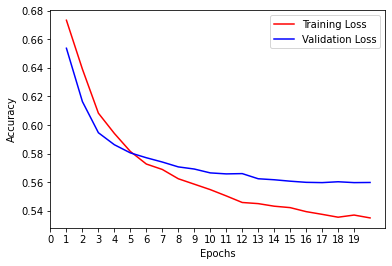

In [11]:
import matplotlib.pyplot as plt

train_loss=[0.6733,0.6391,0.6083,0.5941,0.5815,0.5727,0.5689,0.5624,0.5586,0.5548,0.5504,0.5458,0.5450,0.5432,0.5422,0.5394,0.5375,0.5355,0.5370,0.5350]
val_loss=[0.6537,0.6164,0.5946,0.5862,0.5805,0.5771,0.5741,0.5707,0.5692,0.5665,0.5658,0.5660,0.5624,0.5617,0.5607,0.5599,0.5597,0.5603,0.5597,0.5598]

#train_acc = [.48,.5,.51,.52,.526,.53,.537,.54,.536,.55,.549,.552,.549,.55,.551,.554,.559,.557,.558,.561]
#val_acc = [.48,.51,.52,.53,.531,.536,.545,.547,.551,.556,.559,.561,.563,.561,.557,.561,.564,.564,.571,.572]

epochs = range(1, len(train_loss)+1)
x=range(20)
xi = list(range(len(x)))
plt.plot(epochs, train_loss, 'b',color='red', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xticks(xi, x)
#plt.title('Seq2Seq Learning Curve (Perplexity)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [88]:
#this is to save all the training results to be used by recommender.py
torch.save(model.state_dict(), 'fine_tuned\\fine_tuned_bert_model.pt')
tokenizer.save_pretrained('fine_tuned\\fine_tuned_tokenizer')
with open('fine_tuned\\fine_tuned_bert_config.json', 'w') as f:
    f.write(model.config.to_json_string())

In [91]:
import json
training_info = {'training_loss': train_loss, 'validation_loss': val_loss, 'Val Acc': val_acc}
with open('fine_tuned\\fine_tuning_training_info.json', 'w') as f:
    json.dump(training_info, f)



In [40]:
a=positive=['a reason for being', 'able', 'abound', 'abounding', 'abounds', 'abracadabra', 'absolute', 'absolutely', 'absorbed', 'abundance', 'abundant', 'abundant gratification', 'acaronar', 'accentuactivity', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accommodate', 'accommodated', 'accommodating', 'accommodation', 'accommodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accountability', 'accuracy', 'accurate', 'accurately', 'achievable', 'achieve', 'achievement', 'achievements', 'acknowledgment', 'actability', 'action', 'action for happiness', 'activate', 'active', 'active and constructive steps', 'acts of kindness', 'acumen', 'adaptability', 'adaptable', 'adaptive', 'add', 'addition', 'adequate', 'adjustable', 'admirable', 'admirably', 'admiration', 'admire', 'admired', 'admirer', 'admiring', 'admiringly', 'adorable', 'adore', 'adored', 'adorer', 'adoring', 'adoringly', 'adroit', 'adroitly', 'adulated', 'adulation', 'adulatory', 'advanced', 'advantage', 'advantageous', 'advantageously', 'advantages', 'adventure', 'adventuresome', 'adventurous', 'advocated', 'affability', 'affable', 'affably', 'affection', 'affectionate', 'affinity', 'affirm', 'affirmation', 'affirmative', 'affluence', 'affluent', 'afford', 'affordable', 'affordably', 'ageless', 'agile', 'agilely', 'agility', 'agree', 'agreeable', 'agreeableness', 'agreeably', 'aid', 'aim', 'air', 'airness', 'akashic records', 'alacrity', 'alert', 'alertness', 'aligned', 'alive', 'aliveness', 'all is well', 'allow', 'allowing', 'allure', 'alluring', 'alluringly', 'aloha', 'alternative healing', 'altitudinarian', 'altrucause', 'altruism', 'altruistic', 'altruistically', 'amaze', 'amazed', 'amazement', 'amazes', 'amazing', 'amazing words', 'amazingly', 'ambition', 'ambitious', 'ambitiously', 'ameliorate', 'amenity', 'amiability', 'amiable', 'amiably', 'amicability', 'amicable', 'amicably', 'amin', 'amity', 'ample', 'amply', 'amuse', 'amused', 'amusing', 'amusingly', 'angel', 'angelic', 'animate', 'animated', 'animateness', 'animating', 'animation', 'anticipation', 'apotheosis', 'appeal', 'appealing', 'applaud', 'appreciable', 'appreciate', 'appreciated', 'appreciates', 'appreciation', 'appreciation of beauty', 'appreciative', 'appreciative joy', 'appreciatively', 'appreciativeness', 'appropriate', 'approval', 'approve', 'ardent', 'ardor', 'aroused', 'art of appreciation', 'art of stillness', 'art of wellbeing', 'assertive', 'assertiveness', 'assume your own value', 'assurance', 'astonished', 'astonishing', 'astonishingly', 'astonishment', 'astounding', 'astronomical', 'attentiveness', 'attraction', 'attractive', 'attributional style questionnaire (asq)', 'audacity', 'aurora', 'authentic', 'authentic happiness', 'authenticity', 'awakening', 'aware', 'awareness', 'awe', 'awed', 'awe-gasmic', 'awesome', 'awesomeness','badassery', 'balance', 'balanced', 'ballistic', 'be extraordinary', 'be happy', 'beatify', 'beatitude', 'beautiful', 'beautifully', 'beautify', 'beauty', 'beauty in all things', 'being at rest', 'beingness', 'believable', 'belong', 'belonging', 'beloved', 'benefactor', 'beneficial', 'benefit', 'benefits', 'benevolence', 'benevolent', 'benevolently', 'benevolently cheerful state of mind', 'best', 'best of all possible worlds', 'best-selling', 'better', 'better and better', 'better-known', 'better-than-expected', 'beyond', 'beyond fabulous', 'beyond thank you', 'big vision', 'biophilia', 'blasting', 'blasting love', 'blazing', 'bless', 'blessed', 'blessing', 'blinding', 'bling bling', 'bliss', 'bliss on tap', 'blisscipline', 'blissful', 'blissfulness', 'blithesome', 'blood-brothers', 'bloom', 'blossom', 'blossoming', 'bohemian soul', 'boho-soul', 'boldness', 'bonus', 'bravery', 'breathtaking', 'breeziness', 'bright', 'brighten', 'brightness', 'brilliance', 'brilliant', 'brio', 'briskness', 'bubbling', 'buddhahood', 'budo', 'bullishness', 'buoyancy', 'busting', 'calm', 'candor', 'capability', 'capable', 'capably', 'capital', 'care', 'carefree', 'carefreeness', 'carefulness', 'caress', 'caring', 'celebrate', 'celebration', 'centered', 'centering', 'centering meditation', 'cerebro', 'certain ', 'certainty', 'chakra', 'challenge', 'champion', 'champ’', 'change', 'charisma', 'charismatic', 'charitable', 'charity', 'charm', 'charmer', 'charming', 'cheerful', 'cheerful mood', 'cheerful willingness', 'cheerfulness', 'cheers', 'chi', 'choice', 'citizen of mastery', 'clarity', 'classy', 'clean', 'cleanliness', 'clear', 'clear headed', 'closeness', 'co-creating', 'co-creator', 'cohesion', 'collaboration', 'collected', 'comfort', 'comfortable', 'comforting', 'commitment', 'communication', 'communion', 'community', 'companionship', 'compassion', 'compassionate', 'competence', 'competency', 'competent', 'complimentary words', 'composure', 'concentration', 'concord', 'confidence', 'confident', 'congruence', 'connect', 'connected', 'connectedness', 'connection', 'conquer', 'consciousness', 'consciousness engineering', 'considerate', 'consideration', 'consistency', 'consistent', 'content', 'contented', 'contentment', 'continual stream of synchronicity', 'continuity', 'continuous', 'contribution', 'conviction', 'convincing', 'cool', 'cooperation', 'copacabana', 'cordial', 'corking', 'cosmic awareness', 'courage', 'courteous', 'courtesy', 'coziness', 'crank (up)', 'create', 'creative', 'creative affirmations', 'creative process', 'creativeness', 'creativity', 'cuddle', 'cuddling', 'curiosity', 'curious', 'cute', 'cuteness', 'daimon', 'dandy', 'daring', 'dauwtrappen', 'dazzle', 'dazzled', 'debonair', 'decent', 'decisiveness', 'dedicated', 'deeper part of you', 'defencelessness', 'delicate', 'delicious', 'deliciousness', 'delight', 'delighted', 'delightful', 'delightfully', 'dependability', 'deserve', 'deservedness', 'deservingness', 'desirable', 'desire', 'detachment', 'determination', 'devoted', 'devotion', 'dignity', 'diligence', 'direction', 'discipline', 'discovery', 'discretion', 'dis-identify', 'disney', 'diversity', 'divine', 'do', 'dope', 'dope chill out', 'dream', 'dreamy', 'drive', 'duty', 'dynamic', 'e ma ho', 'eager', 'eagerness', 'earnest', 'earthing', 'ease', 'ease-of-mind', 'easier', 'easily', 'easy', 'easy to approach', 'easy to talk to', 'ebullience', 'ecosophy', 'ecstatic', 'ecstatify', 'educate', 'educated', 'education', 'effectiveness', 'efficacy', 'efficiency', 'efficient', 'effortless ease', 'effortlessly', 'effortlessness', 'ekaggata', 'elated', 'elation', 'electric', 'elegance', 'elevate', 'elevated', 'embody the love', 'embrace', 'empathize', 'empathy', 'emphatic', 'empower', 'empowered', 'empowering', 'empowering words', 'emulate', 'enable', 'enabled', 'enchanted', 'encourage', 'encouraged', 'encouragement', 'encouraging words', 'endless', 'endurance', 'energetic', 'energize', 'energy', 'engage', 'engaged', 'engaging', 'engrossed', 'enjoy', 'enjoyment', 'enlightened', 'enlightenment', 'enlivened', 'enormous', 'enough', 'enthralled', 'enthusiasm', 'enthusiastic', 'entranced', 'equality', 'equanimity', 'equanimous', 'equitable', 'equitably', 'equity', 'erlebnis', 'eternal', 'ethereal', 'eudaemonism', 'eudaemonist', 'eudaemonistic', 'eudaimonia', 'eudamonia', 'eunoia', 'ever-joyous', 'ever-joyous now', 'evolve', 'exaltation', 'exalting', 'excellence', 'excellent', 'exceptional', 'excite', 'excited', 'excited anticipation', 'excitement', 'exciting', 'exemplary', 'exhilarating', 'expansive', 'expectant', 'experience', 'expertise', 'exploration', 'expressing', 'expressiveness', 'exquisite', 'exstatisfy', 'extra', 'extraordinary', 'exuberance', 'exuberant', 'exultant', 'fabulous', 'fair', 'fairness', 'faith', 'faithful', 'fame', 'family', 'famous', 'fancy', 'fantabulous', 'fantastic', 'fascinate', 'fascinated', 'favorite', 'fearless', 'feasible', 'feel good', 'feeling good', 'feistiness', 'feisty', 'felicity', 'festive', 'festiveness', 'fidelity', 'fine', 'fit', 'flashy', 'flaunting', 'flawless', 'flawlessly', 'flexibility', 'flourish', 'flourishing', 'flow', 'flowing', 'focus', 'fondle', 'food', 'forgive', 'forgiveness', 'forgiving', 'fortitude', 'fortuitous', 'free', 'freecycle', 'freedom', 'free-spirited', 'fric-tionlessly', 'friend', 'friendliness', 'friendly', 'friendship', 'frugality', 'ftw', 'fulfill', 'fulfilled', 'fun', 'funerific', 'fun-loving', 'funny jokes', 'funology', 'future', 'game-changer', 'gargantuan', 'gemutlichkeit', 'generate', 'generator of life', 'generavity', 'generosity', 'generous', 'genial', 'genius', 'gentleman', 'genuine', 'genuineness', 'gibigiana', 'giddy', 'gift', 'giggling', 'gigil', 'ginger', 'give', 'giving', 'glad', 'glamor', 'glory', 'glow', 'god', 'goddess', 'godliness', 'going the extra mile', 'goldilocks', 'good', 'good done in secret', 'good fortune', 'good health', 'good indwelling spirit', 'good word', 'good words', 'good-feeling', 'good-humored', 'goodness', 'goodwill', 'gorgeous', 'gorgeousness', 'grace', 'gracefully', 'graciousness', 'grand', 'grandiosity', 'gratefulness', 'gratitude', 'great', 'great zeal', 'greatful', 'groovy', 'grounded', 'grow', 'growth', 'guidance', 'guide', 'guiding', 'gypsy soul', 'habituation', 'hakuna matata', 'halcyon', 'hall of awesomeness', 'halo', 'handsome', 'happily', 'happiness', 'happy', 'happy hearted', 'happy words', 'harmonious', 'harmonize', 'harmony', 'harness', 'health', 'healthy', 'heart', 'heartfelt', 'heart-opening', 'heartwarming', 'heaven', 'heavenly', 'heedful', 'heightened', 'hello', 'help', 'helpful', 'helpfulness', 'helping', 'hero', 'heroism', 'higher consciousness', 'highly distinguished', 'high-spiritedness', 'holiness', 'holistic', 'holy', 'holy spirit', 'honest', 'honesty', 'honey badger', 'honor', 'hope', 'hopefulness', 'hospitable', 'hospitality', 'hot', 'huge', 'human', 'human flourishing', 'humble', 'humor', 'ichariba chode', 'idea', 'idealism', 'ikigai', 'illuminated', 'illumination', 'illustrious', 'imagination', 'improvement', 'inclusion', 'inclusiveness', 'incomparable', 'incredible', 'incredible cuteness', 'independence', 'indwelling', 'ineffability', 'ineffable', 'infinite', 'infinity', 'influence', 'ingenuity', 'in-love', 'inner', 'inner peace', 'inner spirit', 'innocent', 'innovate', 'innovation', 'inquisitive', 'insight', 'insightful', 'insightfulness', 'inspiration', 'inspirational', 'inspirational words', 'inspire', 'inspired', 'inspiring word', 'inspiring words', 'integrity', 'intelligence', 'intelligent', 'intensity', 'intention', 'interconnected', 'interconnectivity', 'interest', 'interested', 'interesting', 'intimacy', 'intrepid', 'intrigued', 'intuition', 'intuitiveness', 'inventiveness', 'investing', 'invigorate', 'invigorated', 'invincible', 'involve', 'involved', 'iridescent', 'jammin’', 'joke', 'jolly', 'jovial', 'joy', 'joyful', 'joyous', 'jubilant', 'jubilingo', 'jumpy', 'just', 'justice', 'juvenescent', 'kaajhuab', 'kaleidoscopes of butterflies', 'kalon', 'keen', 'keep-up', 'ki', 'kilig', 'kind', 'kind words', 'kind-heart', 'kindly', 'kindness', 'kiss', 'kittens', 'knowledge', 'koibito kibun', 'laugh', 'laughing', 'leader', 'leadership', 'leading', 'learn', 'learning', 'leeway', 'let go', 'letting go', 'liberty', 'life', 'life of the party', 'light', 'light fog', 'light-hearted', 'lightworker', 'like', 'live', 'liveliness', 'lively', 'lives through', 'living', 'logic', 'longevity', 'lovable', 'love', 'love fulfilled', 'love words', 'lovely', 'lover of beauty', 'loving', 'loving acceptance', 'loving attention', 'loving feelings', 'loving-kindness', 'loyal', 'loyalty', 'luck', 'lucky', 'lustrous', 'lustrous colors', 'luxury', 'magic', 'magnetic to love', 'magnificent', 'majesty', 'major', 'making a difference', 'many', 'marvelous', 'mastery', 'maturity', 'meaning', 'meaningful', 'meaningful words', 'meditation', 'meliorism', 'mellow', 'memorable', 'mench', 'mercy', 'merit', 'mild', 'mind-blowing', 'mindful', 'mindfulness', 'mindsight', 'miracle', 'mirthful', 'modesty', 'mojo', 'more', 'morphing', 'motivate', 'motivated words', 'motivating words', 'motivation', 'motivational', 'motivational words', 'mourning', 'moved', 'movement', 'moving', 'mutuality', 'myriad', 'namaste', 'nature-made', 'neat', 'neoteny', 'new', 'nice', 'nice words', 'nirvana', 'noble', 'non-duality', 'non-resistance', 'non-resistant', 'nourish', 'nourished', 'nourishing', 'nourishment', 'novaturient', 'nurture', 'nurturing', 'obedient', 'ok', 'okage sama', 'om mani padme hum', 'omg', 'omniscience', 'on', 'oneness', 'one-pointedness', 'oneup', 'onwards', 'open', 'open hearted', 'opening', 'openly', 'open-minded', 'openness', 'opportunity', 'optimism', 'optimist', 'optimistic', 'order', 'orenda', 'organization', 'orientation', 'original', 'originality', 'outcome', 'outernationalist', 'outgoing', 'outstanding', 'overcome', 'overly optimistic', 'owning your power', 'pacify', 'panache', 'paradise', 'paradisiac', 'pardon', 'participation', 'passion', 'passionate', 'patience', 'peace', 'peace of mind', 'peaceful words', 'pep', 'peppiness', 'perceptiveness', 'perfect', 'perfection', 'perkiness', 'permalicious', 'perseverance', 'persistence', 'personal growth', 'petrichor', 'philocalist', 'pick-me-up', 'picturesque', 'pious', 'piquancy', 'play', 'playful', 'playfulness', 'please', 'pleased', 'pleasure', 'plucky', 'polite', 'politeness', 'pollyannaism', 'posichoice', 'posidriving', 'posifit', 'posilenz', 'posimass', 'posiminder', 'posiratio', 'posiripple', 'posirippler', 'posiripples', 'posisinger', 'posisite', 'posistrength', 'positibilitarian', 'positive adjectives', 'positive attitude', 'positive beliefs', 'positive circumstances', 'positive emotions', 'positive energy', 'positive events', 'positive feelings', 'positive mind', 'positive thesaurus', 'positive thinking', 'positive thoughts', 'positive vocabulary', 'positive words', 'positraction', 'positude', 'posivalues', 'posiword', 'possibilitarian', 'pour your love', 'power', 'power words', 'powerful', 'powerful positive words', 'powerful possibility', 'powerful words', 'power-on', 'power-up', 'practicality', 'prana', 'precious', 'precision', 'preparedness', 'presence', 'preservation', 'pretty', 'priceless', 'pride', 'privacy', 'privilege', 'proactive', 'proactivity', 'progress', 'promptness', 'pronia', 'propitious', 'prosperity', 'prosperous', 'protect', 'proto', 'proud', 'punctual', 'punctuality', 'puppies', 'pure', 'purpose', 'positive psychology', 'quaint', 'quality', 'quality words', 'quantum consciousness', 'quantumness', 'queenly', 'quickening', 'quiddity', 'quiescent', 'quiescent mind', 'quiet', 'quietness', 'radiant', 'radiate', 'rainbow', 'rapture', 'rapturous', 'rasasvada', 'rationality', 'readiness', 'ready', 'real', 'reality', 'reason', 'reborn', 'recognition', 'recognize', 'recommend', 'refresh', 'refreshed', 'rejuvenate', 'rejuvenated', 'relatedness', 'relationships', 'relax', 'relaxed', 'releasing', 'relent', 'reliability', 'reliable', 'relief', 'relieve', 'relieved', 'religion', 'remarkable', 'renew', 'renewed', 'renowned', 'repose', 'resilience', 'resilient', 'resourcefulness', 'respect', 'respected', 'responsibility', 'rest', 'rested', 'restore', 'restored', 'revelation', 'reverence', 'revived', 'righteousness', 'rightful', 'ripe', 'risk-taking', 'rockstar', 'romance', 'romantic', 'rosiness', 'sacred', 'sacred space', 'safe', 'safety', 'salvation', 'sassy', 'satisfied', 'save', 'savings', 'savour', 'savouring', 'scope', 'secure', 'secured', 'security', 'self-compassion', 'self-esteem', 'self-expression', 'self-forgiveness', 'self-kindness', 'selflessness', 'self-love', 'self-respect', 'serendipity', 'serene', 'serenity', 'serve', 'service', 'shape-shifting virtuoso', 'shelter', 'shift in focus', 'shine', 'shining', 'show up more present', 'simple', 'simplicity', 'simplify', 'sincerity', 'skill', 'skilled', 'slaying your dragon', 'sleep', 'smart', 'smile', 'smiling', 'soul', 'soulful', 'soulmate', 'soul-stretching', 'space', 'spacious', 'spark', 'sparkle', 'sparkles', 'special', 'spectacular', 'spellbound', 'spirit', 'splendid', 'spontaneity', 'spontaneous', 'spunky', 'stability', 'start', 'steadfastness', 'stellar', 'still', 'stimulated', 'stimulating', 'stimulation', 'strength', 'strive', 'strong words', 'studious', 'study', 'stupendous', 'style', 'sublime', 'succulent', 'sufficient', 'sunniness', 'sunshine', 'supercalifragilistic', 'supercalifragilisticexpialidocious', 'supercharge', 'supercharged', 'superpower', 'support', 'supported', 'supporting', 'supreme', 'surprised', 'sustain', 'sustained', 'swag', 'swaggy', 'sweet', 'sweetheart', 'sweetness', 'sympathetic', 'symptoms of greatness', 'synchronicity', 'synergy', 'systematization', 'tact', 'teach', 'teachable', 'team', 'teamwork', 'temul', 'tenacity', 'tender', 'tenderly', 'thank', 'thankful', 'thankful', 'thankfulness', 'thank-you ', 'the great spirit', 'therapy', 'thrilled', 'thrive', 'thriving', 'tickled', 'tidsoptimist', 'time', 'time optimist', 'timeliness', 'to be', 'to be known', 'to be seen', 'to know', 'to let go', 'to matter', 'tolerance', 'touch', 'touched', 'tradition', 'tranquil', 'tranquility', 'transform', 'transformation', 'transformative', 'transparent', 'triumph', 'trust', 'trusting', 'truth', 'truthfulness', 'ubuntu', 'ultimate', 'unabashed', 'unabashed pleasure', 'unbearably cute', 'unbelievable', 'unconditional', 'understand', 'understanding', 'understood', 'unflappable', 'unhurry', 'unification', 'unification of mind', 'unique', 'unity', 'unreal', 'up', 'upgrade', 'up-leveled', 'uplift', 'upskill', 'useful', 'user-friendly', 'utter amazement', 'valid', 'valuable', 'value', 'values', 'variety', 'veneration', 'verify', 'versatility', 'very', 'viable', 'vibrant', 'victorious', 'victory', 'vigor', 'vim', 'virtue', 'virtuous', 'vitality', 'vocabuleverage', 'vow', 'vulnerability', 'vulnerable', 'walwalun', 'wanderlust', 'warm', 'warmth', 'water', 'wealth', 'web of relatedness', 'welcome', 'welfare', 'well', 'well-being', 'wellness', 'whole', 'wholeheartedly', 'wholeheartedness', 'will', 'willing', 'willing to learn', 'willingness', 'win', 'winnable', 'winning', 'wisdom', 'wise', 'won', 'wonder', 'wonderful', 'wonder-working', 'wondrous', 'world-builder', 'worth', 'worthiness', 'worthiness to take up space', 'worthy', 'wow', 'xenial', 'xenodochial', 'xenophile', 'xfactor', 'xo', 'x-ray vision', 'yaraana', 'yay', 'yea', 'yeah', 'yearn', 'yen', 'yes', 'yesability', 'yesable', 'yippee', 'you are loved', 'young', 'young-at-heart', 'your true value', 'youth', 'youthful', 'yugen', 'yummy', 'zajebiscie', 'zany', 'zappy', 'zeal', 'zealous', 'zest', 'zest for life', 'zestful', 'zesty', 'zing', 'zippy']

In [42]:
b=['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade', 'abrasive', 'abrupt', 'abruptly', 'abscond', 'absence', 'absent-minded', 'absentee', 'absurd', 'absurdity', 'absurdly', 'absurdness', 'abuse', 'abused', 'abuses', 'abusive', 'abysmal', 'abysmally', 'abyss', 'accidental', 'accost', 'accursed', 'accusation', 'accusations', 'accuse', 'accuses', 'accusing', 'accusingly', 'acerbate', 'acerbic', 'acerbically', 'ache', 'ached', 'aches', 'achey', 'aching', 'acrid', 'acridly', 'acridness', 'acrimonious', 'acrimoniously', 'acrimony', 'adamant', 'adamantly', 'addict', 'addicted', 'addicting', 'addicts', 'admonish', 'admonisher', 'admonishingly', 'admonishment', 'admonition', 'adulterate', 'adulterated', 'adulteration', 'adulterier', 'adversarial', 'adversary', 'adverse', 'adversity', 'afflict', 'affliction', 'afflictive', 'affront', 'afraid', 'aggravate', 'aggravating', 'aggravation', 'aggression', 'aggressive', 'aggressiveness', 'aggressor', 'aggrieve', 'aggrieved', 'aggrivation', 'aghast', 'agonies', 'agonize', 'agonizing', 'agonizingly', 'agony', 'aground', 'ail', 'ailing', 'ailment', 'aimless', 'alarm', 'alarmed', 'alarming', 'alarmingly', 'alienate', 'alienated', 'alienation', 'allegation', 'allegations', 'allege', 'allergic', 'allergies', 'allergy', 'aloof', 'altercation', 'ambiguity', 'ambiguous', 'ambivalence', 'ambivalent', 'ambush', 'amiss', 'amputate', 'anarchism', 'anarchist', 'anarchistic', 'anarchy', 'anemic', 'anger', 'angrily', 'angriness', 'angry', 'anguish', 'animosity', 'annihilate', 'annihilation', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoyingly', 'annoys', 'anomalous', 'anomaly', 'antagonism', 'antagonist', 'antagonistic', 'antagonize', 'anti-', 'anti-american', 'anti-israeli', 'anti-occupation', 'anti-proliferation', 'anti-semites', 'anti-social', 'anti-us', 'anti-white', 'antipathy', 'antiquated', 'antithetical', 'anxieties', 'anxiety', 'anxious', 'anxiously', 'anxiousness', 'apathetic', 'apathetically', 'apathy', 'apocalypse', 'apocalyptic', 'apologist', 'apologists', 'appal', 'appall', 'appalled', 'appalling', 'appallingly', 'apprehension', 'apprehensions', 'apprehensive', 'apprehensively', 'arbitrary', 'arcane', 'archaic', 'arduous', 'arduously', 'argumentative', 'arrogance', 'arrogant', 'arrogantly', 'ashamed', 'asinine', 'asininely', 'asinininity', 'askance', 'asperse', 'aspersion', 'aspersions', 'assail', 'assassin', 'assassinate', 'assault', 'assult', 'astray', 'asunder', 'atrocious', 'atrocities', 'atrocity', 'atrophy', 'attack', 'attacks', 'audacious', 'audaciously', 'audaciousness', 'audacity', 'audiciously', 'austere', 'authoritarian', 'autocrat', 'autocratic', 'avalanche', 'avarice', 'avaricious', 'avariciously', 'avenge', 'averse', 'aversion', 'aweful', 'awful', 'awfully', 'awfulness', 'awkward', 'awkwardness', 'ax', 'babble', 'back-logged', 'back-wood', 'back-woods', 'backache', 'backaches', 'backaching', 'backbite', 'backbiting', 'backward', 'backwardness', 'backwood', 'backwoods', 'bad', 'badly', 'baffle', 'baffled', 'bafflement', 'baffling', 'bait', 'balk', 'banal', 'banalize', 'bane', 'banish', 'banishment', 'bankrupt', 'barbarian', 'barbaric', 'barbarically', 'barbarity', 'barbarous', 'barbarously', 'barren', 'baseless', 'bash', 'bashed', 'bashful', 'bashing', 'bastard', 'bastards', 'battered', 'battering', 'batty', 'bearish', 'beastly', 'bedlam', 'bedlamite', 'befoul', 'beg', 'beggar', 'beggarly', 'begging', 'beguile', 'belabor', 'belated', 'beleaguer', 'belie', 'belittle', 'belittled', 'belittling', 'bellicose', 'belligerence', 'belligerent', 'belligerently', 'bemoan', 'bemoaning', 'bemused', 'bent', 'berate', 'bereave', 'bereavement', 'bereft', 'berserk', 'beseech', 'beset', 'besiege', 'besmirch', 'bestial', 'betray', 'betrayal', 'betrayals', 'betrayer', 'betraying', 'betrays', 'bewail', 'beware', 'bewilder', 'bewildered', 'bewildering', 'bewilderingly', 'bewilderment', 'bewitch', 'bias', 'biased', 'biases', 'bicker', 'bickering', 'bid-rigging', 'bigotries', 'bigotry', 'bitch', 'bitchy', 'biting', 'bitingly', 'bitter', 'bitterly', 'bitterness', 'bizarre', 'blab', 'blabber', 'blackmail', 'blah', 'blame', 'blameworthy', 'bland', 'blandish', 'blaspheme', 'blasphemous', 'blasphemy', 'blasted', 'blatant', 'blatantly', 'blather', 'bleak', 'bleakly', 'bleakness', 'bleed', 'bleeding', 'bleeds', 'blemish', 'blind', 'blinding', 'blindingly', 'blindside', 'blister', 'blistering', 'bloated', 'blockage', 'blockhead', 'bloodshed', 'bloodthirsty', 'bloody', 'blotchy', 'blow', 'blunder', 'blundering', 'blunders', 'blunt', 'blur', 'bluring', 'blurred', 'blurring', 'blurry', 'blurs', 'blurt', 'boastful', 'boggle', 'bogus', 'boil', 'boiling', 'boisterous', 'bomb', 'bombard', 'bombardment', 'bombastic', 'bondage', 'bonkers', 'bore', 'bored', 'boredom', 'bores', 'boring', 'botch', 'bother', 'bothered', 'bothering', 'bothers', 'bothersome', 'bowdlerize', 'boycott', 'braggart', 'bragger', 'brainless', 'brainwash', 'brash', 'brashly', 'brashness', 'brat', 'bravado', 'brazen', 'brazenly', 'brazenness', 'breach', 'break', 'break-up', 'break-ups', 'breakdown', 'breaking', 'breaks', 'breakup', 'breakups', 'bribery', 'brimstone', 'bristle', 'brittle', 'broke', 'broken', 'broken-hearted', 'brood', 'browbeat', 'bruise', 'bruised', 'bruises', 'bruising', 'brusque', 'brutal', 'brutalising', 'brutalities', 'brutality', 'brutalize', 'brutalizing', 'brutally', 'brute', 'brutish', 'bs', 'buckle', 'bug', 'bugging', 'buggy', 'bugs', 'bulkier', 'bulkiness', 'bulky', 'bulkyness', 'bull****', 'bull----', 'bullies', 'bullshit', 'bullshyt', 'bully', 'bullying', 'bullyingly', 'bum', 'bump', 'bumped', 'bumping', 'bumpping', 'bumps', 'bumpy', 'bungle', 'bungler', 'bungling', 'bunk', 'burden', 'burdensome', 'burdensomely', 'burn', 'burned', 'burning', 'burns', 'bust', 'busts', 'busybody', 'butcher', 'butchery', 'buzzing', 'byzantine', 'cackle', 'calamities', 'calamitous', 'calamitously', 'calamity', 'callous', 'calumniate', 'calumniation', 'calumnies', 'calumnious', 'calumniously', 'calumny', 'cancer', 'cancerous', 'cannibal', 'cannibalize', 'capitulate', 'capricious', 'capriciously', 'capriciousness', 'capsize', 'careless', 'carelessness', 'caricature', 'carnage', 'carp', 'cartoonish', 'cash-strapped', 'castigate', 'castrated', 'casualty', 'cataclysm', 'cataclysmal', 'cataclysmic', 'cataclysmically', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically', 'catastrophies', 'caustic', 'caustically', 'cautionary', 'cave', 'censure', 'chafe', 'chaff', 'chagrin', 'challenging', 'chaos', 'chaotic', 'chasten', 'chastise', 'chastisement', 'chatter', 'chatterbox', 'cheap', 'cheapen', 'cheaply', 'cheat', 'cheated', 'cheater', 'cheating', 'cheats', 'checkered', 'cheerless', 'cheesy', 'chide', 'childish', 'chill', 'chilly', 'chintzy', 'choke', 'choleric', 'choppy', 'chore', 'chronic', 'chunky', 'clamor', 'clamorous', 'clash', 'cliche', 'cliched', 'clique', 'clog', 'clogged', 'clogs', 'cloud', 'clouding', 'cloudy', 'clueless', 'clumsy', 'clunky', 'coarse', 'cocky', 'coerce', 'coercion', 'coercive', 'cold', 'coldly', 'collapse', 'collude', 'collusion', 'combative', 'combust', 'comical', 'commiserate', 'commonplace', 'commotion', 'commotions', 'complacent', 'complain', 'complained', 'complaining', 'complains', 'complaint', 'complaints', 'complex', 'complicated', 'complication', 'complicit', 'compulsion', 'compulsive', 'concede', 'conceded', 'conceit', 'conceited', 'concen', 'concens', 'concern', 'concerned', 'concerns', 'concession', 'concessions', 'condemn', 'condemnable', 'condemnation', 'condemned', 'condemns', 'condescend', 'condescending', 'condescendingly', 'condescension', 'confess', 'confession', 'confessions', 'confined', 'conflict', 'conflicted', 'conflicting', 'conflicts', 'confound', 'confounded', 'confounding', 'confront', 'confrontation', 'confrontational', 'confuse', 'confused', 'confuses', 'confusing', 'confusion', 'confusions', 'congested', 'congestion', 'cons', 'conscons', 'conservative', 'conspicuous', 'conspicuously', 'conspiracies', 'conspiracy', 'conspirator', 'conspiratorial', 'conspire', 'consternation', 'contagious', 'contaminate', 'contaminated', 'contaminates', 'contaminating', 'contamination', 'contempt', 'contemptible', 'contemptuous', 'contemptuously', 'contend', 'contention', 'contentious', 'contort', 'contortions', 'contradict', 'contradiction', 'contradictory', 'contrariness', 'contravene', 'contrive', 'contrived', 'controversial', 'controversy', 'convoluted', 'corrode', 'corrosion', 'corrosions', 'corrosive', 'corrupt', 'corrupted', 'corrupting', 'corruption', 'corrupts', 'corruptted', 'costlier', 'costly', 'counter-productive', 'counterproductive', 'coupists', 'covetous', 'coward', 'cowardly', 'crabby', 'crack', 'cracked', 'cracks', 'craftily', 'craftly', 'crafty', 'cramp', 'cramped', 'cramping', 'cranky', 'crap', 'crappy', 'craps', 'crash', 'crashed', 'crashes', 'crashing', 'crass', 'craven', 'cravenly', 'craze', 'crazily', 'craziness', 'crazy', 'creak', 'creaking', 'creaks', 'credulous', 'creep', 'creeping', 'creeps', 'creepy', 'crept', 'crime', 'criminal', 'cringe', 'cringed', 'cringes', 'cripple', 'crippled', 'cripples', 'crippling', 'crisis', 'critic', 'critical', 'criticism', 'criticisms', 'criticize', 'criticized', 'criticizing', 'critics', 'cronyism', 'crook', 'crooked', 'crooks', 'crowded', 'crowdedness', 'crude', 'cruel', 'crueler', 'cruelest', 'cruelly', 'cruelness', 'cruelties', 'cruelty', 'crumble', 'crumbling', 'crummy', 'crumple', 'crumpled', 'crumples', 'crush', 'crushed', 'crushing', 'cry', 'culpable', 'culprit', 'cumbersome', 'cunt', 'cunts', 'cuplrit', 'curse', 'cursed', 'curses', 'curt', 'cuss', 'cussed', 'cutthroat', 'cynical', 'cynicism', 'd*mn', 'damage', 'damaged', 'damages', 'damaging', 'damn', 'damnable', 'damnably', 'damnation', 'damned', 'damning', 'damper', 'danger', 'dangerous', 'dangerousness', 'dark', 'darken', 'darkened', 'darker', 'darkness', 'dastard', 'dastardly', 'daunt', 'daunting', 'dauntingly', 'dawdle', 'daze', 'dazed', 'dead', 'deadbeat', 'deadlock', 'deadly', 'deadweight', 'deaf', 'dearth', 'death', 'debacle', 'debase', 'debasement', 'debaser', 'debatable', 'debauch', 'debaucher', 'debauchery', 'debilitate', 'debilitating', 'debility', 'debt', 'debts', 'decadence', 'decadent', 'decay', 'decayed', 'deceit', 'deceitful', 'deceitfully', 'deceitfulness', 'deceive', 'deceiver', 'deceivers', 'deceiving', 'deception', 'deceptive', 'deceptively', 'declaim', 'decline', 'declines', 'declining', 'decrement', 'decrepit', 'decrepitude', 'decry', 'defamation', 'defamations', 'defamatory', 'defame', 'defect', 'defective', 'defects', 'defensive', 'defiance', 'defiant', 'defiantly', 'deficiencies', 'deficiency', 'deficient', 'defile', 'defiler', 'deform', 'deformed', 'defrauding', 'defunct', 'defy', 'degenerate', 'degenerately', 'degeneration', 'degradation', 'degrade', 'degrading', 'degradingly', 'dehumanization', 'dehumanize', 'deign', 'deject', 'dejected', 'dejectedly', 'dejection', 'delay', 'delayed', 'delaying', 'delays', 'delinquency', 'delinquent', 'delirious', 'delirium', 'delude', 'deluded', 'deluge', 'delusion', 'delusional', 'delusions', 'demean', 'demeaning', 'demise', 'demolish', 'demolisher', 'demon', 'demonic', 'demonize', 'demonized', 'demonizes', 'demonizing', 'demoralize', 'demoralizing', 'demoralizingly', 'denial', 'denied', 'denies', 'denigrate', 'denounce', 'dense', 'dent', 'dented', 'dents', 'denunciate', 'denunciation', 'denunciations', 'deny', 'denying', 'deplete', 'deplorable', 'deplorably', 'deplore', 'deploring', 'deploringly', 'deprave', 'depraved', 'depravedly', 'deprecate', 'depress', 'depressed', 'depressing', 'depressingly', 'depression', 'depressions', 'deprive', 'deprived', 'deride', 'derision', 'derisive', 'derisively', 'derisiveness', 'derogatory', 'desecrate', 'desert', 'desertion', 'desiccate', 'desiccated', 'desititute', 'desolate', 'desolately', 'desolation', 'despair', 'despairing', 'despairingly', 'desperate', 'desperately', 'desperation', 'despicable', 'despicably', 'despise', 'despised', 'despoil', 'despoiler', 'despondence', 'despondency', 'despondent', 'despondently', 'despot', 'despotic', 'despotism', 'destabilisation', 'destains', 'destitute', 'destitution', 'destroy', 'destroyer', 'destruction', 'destructive', 'desultory', 'deter', 'deteriorate', 'deteriorating', 'deterioration', 'deterrent', 'detest', 'detestable', 'detestably', 'detested', 'detesting', 'detests', 'detract', 'detracted', 'detracting', 'detraction', 'detracts', 'detriment', 'detrimental', 'devastate', 'devastated', 'devastates', 'devastating', 'devastatingly', 'devastation', 'deviate', 'deviation', 'devil', 'devilish', 'devilishly', 'devilment', 'devilry', 'devious', 'deviously', 'deviousness', 'devoid', 'diabolic', 'diabolical', 'diabolically', 'diametrically', 'diappointed', 'diatribe', 'diatribes', 'dick', 'dictator', 'dictatorial', 'die', 'die-hard', 'died', 'dies', 'difficult', 'difficulties', 'difficulty', 'diffidence', 'dilapidated', 'dilemma', 'dilly-dally', 'dim', 'dimmer', 'din', 'ding', 'dings', 'dinky', 'dire', 'direly', 'direness', 'dirt', 'dirtbag', 'dirtbags', 'dirts', 'dirty', 'disable', 'disabled', 'disaccord', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages', 'disaffect', 'disaffected', 'disaffirm', 'disagree', 'disagreeable', 'disagreeably', 'disagreed', 'disagreeing', 'disagreement', 'disagrees', 'disallow', 'disapointed', 'disapointing', 'disapointment', 'disappoint', 'disappointed', 'disappointing', 'disappointingly', 'disappointment', 'disappointments', 'disappoints', 'disapprobation', 'disapproval', 'disapprove', 'disapproving', 'disarm', 'disarray', 'disaster', 'disasterous', 'disastrous', 'disastrously', 'disavow', 'disavowal', 'disbelief', 'disbelieve', 'disbeliever', 'disclaim', 'discombobulate', 'discomfit', 'discomfititure', 'discomfort', 'discompose', 'disconcert', 'disconcerted', 'disconcerting', 'disconcertingly', 'disconsolate', 'disconsolately', 'disconsolation', 'discontent', 'discontented', 'discontentedly', 'discontinued', 'discontinuity', 'discontinuous', 'discord', 'discordance', 'discordant', 'discountenance', 'discourage', 'discouragement', 'discouraging', 'discouragingly', 'discourteous', 'discourteously', 'discoutinous', 'discredit', 'discrepant', 'discriminate', 'discrimination', 'discriminatory', 'disdain', 'disdained', 'disdainful', 'disdainfully', 'disfavor', 'disgrace', 'disgraced', 'disgraceful', 'disgracefully', 'disgruntle', 'disgruntled', 'disgust', 'disgusted', 'disgustedly', 'disgustful', 'disgustfully', 'disgusting', 'disgustingly', 'dishearten', 'disheartening', 'dishearteningly', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor', 'dishonorable', 'dishonorablely', 'disillusion', 'disillusioned', 'disillusionment', 'disillusions', 'disinclination', 'disinclined', 'disingenuous', 'disingenuously', 'disintegrate', 'disintegrated', 'disintegrates', 'disintegration', 'disinterest', 'disinterested', 'dislike', 'disliked', 'dislikes', 'disliking', 'dislocated', 'disloyal', 'disloyalty', 'dismal', 'dismally', 'dismalness', 'dismay', 'dismayed', 'dismaying', 'dismayingly', 'dismissive', 'dismissively', 'disobedience', 'disobedient', 'disobey', 'disoobedient', 'disorder', 'disordered', 'disorderly', 'disorganized', 'disorient', 'disoriented', 'disown', 'disparage', 'disparaging', 'disparagingly', 'dispensable', 'dispirit', 'dispirited', 'dispiritedly', 'dispiriting', 'displace', 'displaced', 'displease', 'displeased', 'displeasing', 'displeasure', 'disproportionate', 'disprove', 'disputable', 'dispute', 'disputed', 'disquiet', 'disquieting', 'disquietingly', 'disquietude', 'disregard', 'disregardful', 'disreputable', 'disrepute', 'disrespect', 'disrespectable', 'disrespectablity', 'disrespectful', 'disrespectfully', 'disrespectfulness', 'disrespecting', 'disrupt', 'disruption', 'disruptive', 'diss', 'dissapointed', 'dissappointed', 'dissappointing', 'dissatisfaction', 'dissatisfactory', 'dissatisfied', 'dissatisfies', 'dissatisfy', 'dissatisfying', 'dissed', 'dissemble', 'dissembler', 'dissension', 'dissent', 'dissenter', 'dissention', 'disservice', 'disses', 'dissidence', 'dissident', 'dissidents', 'dissing', 'dissocial', 'dissolute', 'dissolution', 'dissonance', 'dissonant', 'dissonantly', 'dissuade', 'dissuasive', 'distains', 'distaste', 'distasteful', 'distastefully', 'distort', 'distorted', 'distortion', 'distorts', 'distract', 'distracting', 'distraction', 'distraught', 'distraughtly', 'distraughtness', 'distress', 'distressed', 'distressing', 'distressingly', 'distrust', 'distrustful', 'distrusting', 'disturb', 'disturbance', 'disturbed', 'disturbing', 'disturbingly', 'disunity', 'disvalue', 'divergent', 'divisive', 'divisively', 'divisiveness', 'dizzing', 'dizzingly', 'dizzy', 'doddering', 'dodgey', 'dogged', 'doggedly', 'dogmatic', 'doldrums', 'domineer', 'domineering', 'donside', 'doom', 'doomed', 'doomsday', 'dope', 'doubt', 'doubtful', 'doubtfully', 'doubts', 'douchbag', 'douchebag', 'douchebags', 'downbeat', 'downcast', 'downer', 'downfall', 'downfallen', 'downgrade', 'downhearted', 'downheartedly', 'downhill', 'downside', 'downsides', 'downturn', 'downturns', 'drab', 'draconian', 'draconic', 'drag', 'dragged', 'dragging', 'dragoon', 'drags', 'drain', 'drained', 'draining', 'drains', 'drastic', 'drastically', 'drawback', 'drawbacks', 'dread', 'dreadful', 'dreadfully', 'dreadfulness', 'dreary', 'dripped', 'dripping', 'drippy', 'drips', 'drones', 'droop', 'droops', 'drop-out', 'drop-outs', 'dropout', 'dropouts', 'drought', 'drowning', 'drunk', 'drunkard', 'drunken', 'dubious', 'dubiously', 'dubitable', 'dud', 'dull', 'dullard', 'dumb', 'dumbfound', 'dump', 'dumped', 'dumping', 'dumps', 'dunce', 'dungeon', 'dungeons', 'dupe', 'dust', 'dusty', 'dwindling', 'dying', 'earsplitting', 'eccentric', 'eccentricity', 'effigy', 'effrontery', 'egocentric', 'egomania', 'egotism', 'egotistical', 'egotistically', 'egregious', 'egregiously', 'election-rigger', 'elimination', 'emaciated', 'emasculate', 'embarrass', 'embarrassing', 'embarrassingly', 'embarrassment', 'embattled', 'embroil', 'embroiled', 'embroilment', 'emergency', 'emphatic', 'emphatically', 'emptiness', 'encroach', 'encroachment', 'endanger', 'enemies', 'enemy', 'enervate', 'enfeeble', 'enflame', 'engulf', 'enjoin', 'enmity', 'enrage', 'enraged', 'enraging', 'enslave', 'entangle', 'entanglement', 'entrap', 'entrapment', 'envious', 'enviously', 'enviousness', 'epidemic', 'equivocal', 'erase', 'erode', 'erodes', 'erosion', 'err', 'errant', 'erratic', 'erratically', 'erroneous', 'erroneously', 'error', 'errors', 'eruptions', 'escapade', 'eschew', 'estranged', 'evade', 'evasion', 'evasive', 'evil', 'evildoer', 'evils', 'eviscerate', 'exacerbate', 'exagerate', 'exagerated', 'exagerates', 'exaggerate', 'exaggeration', 'exasperate', 'exasperated', 'exasperating', 'exasperatingly', 'exasperation', 'excessive', 'excessively', 'exclusion', 'excoriate', 'excruciating', 'excruciatingly', 'excuse', 'excuses', 'execrate', 'exhaust', 'exhausted', 'exhaustion', 'exhausts', 'exhorbitant', 'exhort', 'exile', 'exorbitant', 'exorbitantance', 'exorbitantly', 'expel', 'expensive', 'expire', 'expired', 'explode', 'exploit', 'exploitation', 'explosive', 'expropriate', 'expropriation', 'expulse', 'expunge', 'exterminate', 'extermination', 'extinguish', 'extort', 'extortion', 'extraneous', 'extravagance', 'extravagant', 'extravagantly', 'extremism', 'extremist', 'extremists', 'eyesore', 'f**k', 'fabricate', 'fabrication', 'facetious', 'facetiously', 'fail', 'failed', 'failing', 'fails', 'failure', 'failures', 'faint', 'fainthearted', 'faithless', 'fake', 'fall', 'fallacies', 'fallacious', 'fallaciously', 'fallaciousness', 'fallacy', 'fallen', 'falling', 'fallout', 'falls', 'false', 'falsehood', 'falsely', 'falsify', 'falter', 'faltered', 'famine', 'famished', 'fanatic', 'fanatical', 'fanatically', 'fanaticism', 'fanatics', 'fanciful', 'far-fetched', 'farce', 'farcical', 'farcical-yet-provocative', 'farcically', 'farfetched', 'fascism', 'fascist', 'fastidious', 'fastidiously', 'fastuous', 'fat', 'fat-cat', 'fat-cats', 'fatal', 'fatalistic', 'fatalistically', 'fatally', 'fatcat', 'fatcats', 'fateful', 'fatefully', 'fathomless', 'fatigue', 'fatigued', 'fatique', 'fatty', 'fatuity', 'fatuous', 'fatuously', 'fault', 'faults', 'faulty', 'fawningly', 'faze', 'fear', 'fearful', 'fearfully', 'fears', 'fearsome', 'feckless', 'feeble', 'feeblely', 'feebleminded', 'feign', 'feint', 'fell', 'felon', 'felonious', 'ferociously', 'ferocity', 'fetid', 'fever', 'feverish', 'fevers', 'fiasco', 'fib', 'fibber', 'fickle', 'fiction', 'fictional', 'fictitious', 'fidget', 'fidgety', 'fiend', 'fiendish', 'fierce', 'figurehead', 'filth', 'filthy', 'finagle', 'finicky', 'fissures', 'fist', 'flabbergast', 'flabbergasted', 'flagging', 'flagrant', 'flagrantly', 'flair', 'flairs', 'flak', 'flake', 'flakey', 'flakieness', 'flaking', 'flaky', 'flare', 'flares', 'flareup', 'flareups', 'flat-out', 'flaunt', 'flaw', 'flawed', 'flaws', 'flee', 'fleed', 'fleeing', 'fleer', 'flees', 'fleeting', 'flicering', 'flicker', 'flickering', 'flickers', 'flighty', 'flimflam', 'flimsy', 'flirt', 'flirty', 'floored', 'flounder', 'floundering', 'flout', 'fluster', 'foe', 'fool', 'fooled', 'foolhardy', 'foolish', 'foolishly', 'foolishness', 'forbid', 'forbidden', 'forbidding', 'forceful', 'foreboding', 'forebodingly', 'forfeit', 'forged', 'forgetful', 'forgetfully', 'forgetfulness', 'forlorn', 'forlornly', 'forsake', 'forsaken', 'forswear', 'foul', 'foully', 'foulness', 'fractious', 'fractiously', 'fracture', 'fragile', 'fragmented', 'frail', 'frantic', 'frantically', 'franticly', 'fraud', 'fraudulent', 'fraught', 'frazzle', 'frazzled', 'freak', 'freaking', 'freakish', 'freakishly', 'freaks', 'freeze', 'freezes', 'freezing', 'frenetic', 'frenetically', 'frenzied', 'frenzy', 'fret', 'fretful', 'frets', 'friction', 'frictions', 'fried', 'friggin', 'frigging', 'fright', 'frighten', 'frightening', 'frighteningly', 'frightful', 'frightfully', 'frigid', 'frost', 'frown', 'froze', 'frozen', 'fruitless', 'fruitlessly', 'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration', 'frustrations', 'fuck', 'fucking', 'fudge', 'fugitive', 'full-blown', 'fulminate', 'fumble', 'fume', 'fumes', 'fundamentalism', 'funky', 'funnily', 'funny', 'furious', 'furiously', 'furor', 'fury', 'fuss', 'fussy', 'fustigate', 'fusty', 'futile', 'futilely', 'futility', 'fuzzy', 'gabble', 'gaff', 'gaffe', 'gainsay', 'gainsayer', 'gall', 'galling', 'gallingly', 'galls', 'gangster', 'gape', 'garbage', 'garish', 'gasp', 'gauche', 'gaudy', 'gawk', 'gawky', 'geezer', 'genocide', 'get-rich', 'ghastly', 'ghetto', 'ghosting', 'gibber', 'gibberish', 'gibe', 'giddy', 'gimmick', 'gimmicked', 'gimmicking', 'gimmicks', 'gimmicky', 'glare', 'glaringly', 'glib', 'glibly', 'glitch', 'glitches', 'gloatingly', 'gloom', 'gloomy', 'glower', 'glum', 'glut', 'gnawing', 'goad', 'goading', 'god-awful', 'goof', 'goofy', 'goon', 'gossip', 'graceless', 'gracelessly', 'graft', 'grainy', 'grapple', 'grate', 'grating', 'gravely', 'greasy', 'greed', 'greedy', 'grief', 'grievance', 'grievances', 'grieve', 'grieving', 'grievous', 'grievously', 'grim', 'grimace', 'grind', 'gripe', 'gripes', 'grisly', 'gritty', 'gross', 'grossly', 'grotesque', 'grouch', 'grouchy', 'groundless', 'grouse', 'growl', 'grudge', 'grudges', 'grudging', 'grudgingly', 'gruesome', 'gruesomely', 'gruff', 'grumble', 'grumpier', 'grumpiest', 'grumpily', 'grumpish', 'grumpy', 'guile', 'guilt', 'guiltily', 'guilty', 'gullible', 'gutless', 'gutter', 'hack', 'hacks', 'haggard', 'haggle', 'hairloss', 'halfhearted', 'halfheartedly', 'hallucinate', 'hallucination', 'hamper', 'hampered', 'handicapped', 'hang', 'hangs', 'haphazard', 'hapless', 'harangue', 'harass', 'harassed', 'harasses', 'harassment', 'harboring', 'harbors', 'hard', 'hard-hit', 'hard-line', 'hard-liner', 'hardball', 'harden', 'hardened', 'hardheaded', 'hardhearted', 'hardliner', 'hardliners', 'hardship', 'hardships', 'harm', 'harmed', 'harmful', 'harms', 'harpy', 'harridan', 'harried', 'harrow', 'harsh', 'harshly', 'hasseling', 'hassle', 'hassled', 'hassles', 'haste', 'hastily', 'hasty', 'hate', 'hated', 'hateful', 'hatefully', 'hatefulness', 'hater', 'haters', 'hates', 'hating', 'hatred', 'haughtily', 'haughty', 'haunt', 'haunting', 'havoc', 'hawkish', 'haywire', 'hazard', 'hazardous', 'haze', 'hazy', 'head-aches', 'headache', 'headaches', 'heartbreaker', 'heartbreaking', 'heartbreakingly', 'heartless', 'heathen', 'heavy-handed', 'heavyhearted', 'heck', 'heckle', 'heckled', 'heckles', 'hectic', 'hedge', 'hedonistic', 'heedless', 'hefty', 'hegemonism', 'hegemonistic', 'hegemony', 'heinous', 'hell', 'hell-bent', 'hellion', 'hells', 'helpless', 'helplessly', 'helplessness', 'heresy', 'heretic', 'heretical', 'hesitant', 'hestitant', 'hideous', 'hideously', 'hideousness', 'high-priced', 'hiliarious', 'hinder', 'hindrance', 'hiss', 'hissed', 'hissing', 'ho-hum', 'hoard', 'hoax', 'hobble', 'hogs', 'hollow', 'hoodium', 'hoodwink', 'hooligan', 'hopeless', 'hopelessly', 'hopelessness', 'horde', 'horrendous', 'horrendously', 'horrible', 'horrid', 'horrific', 'horrified', 'horrifies', 'horrify', 'horrifying', 'horrifys', 'hostage', 'hostile', 'hostilities', 'hostility', 'hotbeds', 'hothead', 'hotheaded', 'hothouse', 'hubris', 'huckster', 'hum', 'humid', 'humiliate', 'humiliating', 'humiliation', 'humming', 'hung', 'hurt', 'hurted', 'hurtful', 'hurting', 'hurts', 'hustler', 'hype', 'hypocricy', 'hypocrisy', 'hypocrite', 'hypocrites', 'hypocritical', 'hypocritically', 'hysteria', 'hysteric', 'hysterical', 'hysterically', 'hysterics', 'idiocies', 'idiocy', 'idiot', 'idiotic', 'idiotically', 'idiots', 'idle', 'ignoble', 'ignominious', 'ignominiously', 'ignominy', 'ignorance', 'ignorant', 'ignore', 'ill-advised', 'ill-conceived', 'ill-defined', 'ill-designed', 'ill-fated', 'ill-favored', 'ill-formed', 'ill-mannered', 'ill-natured', 'ill-sorted', 'ill-tempered', 'ill-treated', 'ill-treatment', 'ill-usage', 'ill-used', 'illegal', 'illegally', 'illegitimate', 'illicit', 'illiterate', 'illness', 'illogic', 'illogical', 'illogically', 'illusion', 'illusions', 'illusory', 'imaginary', 'imbalance', 'imbecile', 'imbroglio', 'immaterial', 'immature', 'imminence', 'imminently', 'immobilized', 'immoderate', 'immoderately', 'immodest', 'immoral', 'immorality', 'immorally', 'immovable', 'impair', 'impaired', 'impasse', 'impatience', 'impatient', 'impatiently', 'impeach', 'impedance', 'impede', 'impediment', 'impending', 'impenitent', 'imperfect', 'imperfection', 'imperfections', 'imperfectly', 'imperialist', 'imperil', 'imperious', 'imperiously', 'impermissible', 'impersonal', 'impertinent', 'impetuous', 'impetuously', 'impiety', 'impinge', 'impious', 'implacable', 'implausible', 'implausibly', 'implicate', 'implication', 'implode', 'impolite', 'impolitely', 'impolitic', 'importunate', 'importune', 'impose', 'imposers', 'imposing', 'imposition', 'impossible', 'impossiblity', 'impossibly', 'impotent', 'impoverish', 'impoverished', 'impractical', 'imprecate', 'imprecise', 'imprecisely', 'imprecision', 'imprison', 'imprisonment', 'improbability', 'improbable', 'improbably', 'improper', 'improperly', 'impropriety', 'imprudence', 'imprudent', 'impudence', 'impudent', 'impudently', 'impugn', 'impulsive', 'impulsively', 'impunity', 'impure', 'impurity', 'inability', 'inaccuracies', 'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactive', 'inadequacy', 'inadequate', 'inadequately', 'inadverent', 'inadverently', 'inadvisable', 'inadvisably', 'inane', 'inanely', 'inappropriate', 'inappropriately', 'inapt', 'inaptitude', 'inarticulate', 'inattentive', 'inaudible', 'incapable', 'incapably', 'incautious', 'incendiary', 'incense', 'incessant', 'incessantly', 'incite', 'incitement', 'incivility', 'inclement', 'incognizant', 'incoherence', 'incoherent', 'incoherently', 'incommensurate', 'incomparable', 'incomparably', 'incompatability', 'incompatibility', 'incompatible', 'incompetence', 'incompetent', 'incompetently', 'incomplete', 'incompliant', 'incomprehensible', 'incomprehension', 'inconceivable', 'inconceivably', 'incongruous', 'incongruously', 'inconsequent', 'inconsequential', 'inconsequentially', 'inconsequently', 'inconsiderate', 'inconsiderately', 'inconsistence', 'inconsistencies', 'inconsistency', 'inconsistent', 'inconsolable', 'inconsolably', 'inconstant', 'inconvenience', 'inconveniently', 'incorrect', 'incorrectly', 'incorrigible', 'incorrigibly', 'incredulous', 'incredulously', 'inculcate', 'indecency', 'indecent', 'indecently', 'indecision', 'indecisive', 'indecisively', 'indecorum', 'indefensible', 'indelicate', 'indeterminable', 'indeterminably', 'indeterminate', 'indifference', 'indifferent', 'indigent', 'indignant', 'indignantly', 'indignation', 'indignity', 'indiscernible', 'indiscreet', 'indiscreetly', 'indiscretion', 'indiscriminate', 'indiscriminately', 'indiscriminating', 'indistinguishable', 'indoctrinate', 'indoctrination', 'indolent', 'indulge', 'ineffective', 'ineffectively', 'ineffectiveness', 'ineffectual', 'ineffectually', 'ineffectualness', 'inefficacious', 'inefficacy', 'inefficiency', 'inefficient', 'inefficiently', 'inelegance', 'inelegant', 'ineligible', 'ineloquent', 'ineloquently', 'inept', 'ineptitude', 'ineptly', 'inequalities', 'inequality', 'inequitable', 'inequitably', 'inequities', 'inescapable', 'inescapably', 'inessential', 'inevitable', 'inevitably', 'inexcusable', 'inexcusably', 'inexorable', 'inexorably', 'inexperience', 'inexperienced', 'inexpert', 'inexpertly', 'inexpiable', 'inexplainable', 'inextricable', 'inextricably', 'infamous', 'infamously', 'infamy', 'infected', 'infection', 'infections', 'inferior', 'inferiority', 'infernal', 'infest', 'infested', 'infidel', 'infidels', 'infiltrator', 'infiltrators', 'infirm', 'inflame', 'inflammation', 'inflammatory', 'inflammed', 'inflated', 'inflationary', 'inflexible', 'inflict', 'infraction', 'infringe', 'infringement', 'infringements', 'infuriate', 'infuriated', 'infuriating', 'infuriatingly', 'inglorious', 'ingrate', 'ingratitude', 'inhibit', 'inhibition', 'inhospitable', 'inhospitality', 'inhuman', 'inhumane', 'inhumanity', 'inimical', 'inimically', 'iniquitous', 'iniquity', 'injudicious', 'injure', 'injurious', 'injury', 'injustice', 'injustices', 'innuendo', 'inoperable', 'inopportune', 'inordinate', 'inordinately', 'insane', 'insanely', 'insanity', 'insatiable', 'insecure', 'insecurity', 'insensible', 'insensitive', 'insensitively', 'insensitivity', 'insidious', 'insidiously', 'insignificance', 'insignificant', 'insignificantly', 'insincere', 'insincerely', 'insincerity', 'insinuate', 'insinuating', 'insinuation', 'insociable', 'insolence', 'insolent', 'insolently', 'insolvent', 'insouciance', 'instability', 'instable', 'instigate', 'instigator', 'instigators', 'insubordinate', 'insubstantial', 'insubstantially', 'insufferable', 'insufferably', 'insufficiency', 'insufficient', 'insufficiently', 'insular', 'insult', 'insulted', 'insulting', 'insultingly', 'insults', 'insupportable', 'insupportably', 'insurmountable', 'insurmountably', 'insurrection', 'intefere', 'inteferes', 'intense', 'interfere', 'interference', 'interferes', 'intermittent', 'interrupt', 'interruption', 'interruptions', 'intimidate', 'intimidating', 'intimidatingly', 'intimidation', 'intolerable', 'intolerablely', 'intolerance', 'intoxicate', 'intractable', 'intransigence', 'intransigent', 'intrude', 'intrusion', 'intrusive', 'inundate', 'inundated', 'invader', 'invalid', 'invalidate', 'invalidity', 'invasive', 'invective', 'inveigle', 'invidious', 'invidiously', 'invidiousness', 'invisible', 'involuntarily', 'involuntary', 'irascible', 'irate', 'irately', 'ire', 'irk', 'irked', 'irking', 'irks', 'irksome', 'irksomely', 'irksomeness', 'irksomenesses', 'ironic', 'ironical', 'ironically', 'ironies', 'irony', 'irragularity', 'irrational', 'irrationalities', 'irrationality', 'irrationally', 'irrationals', 'irreconcilable', 'irrecoverable', 'irrecoverableness', 'irrecoverablenesses', 'irrecoverably', 'irredeemable', 'irredeemably', 'irreformable', 'irregular', 'irregularity', 'irrelevance', 'irrelevant', 'irreparable', 'irreplacible', 'irrepressible', 'irresolute', 'irresolvable', 'irresponsible', 'irresponsibly', 'irretating', 'irretrievable', 'irreversible', 'irritable', 'irritably', 'irritant', 'irritate', 'irritated', 'irritating', 'irritation', 'irritations', 'isolate', 'isolated', 'isolation', 'issue', 'issues', 'itch', 'itching', 'itchy', 'jabber', 'jaded', 'jagged', 'jam', 'jarring', 'jaundiced', 'jealous', 'jealously', 'jealousness', 'jealousy', 'jeer', 'jeering', 'jeeringly', 'jeers', 'jeopardize', 'jeopardy', 'jerk', 'jerky', 'jitter', 'jitters', 'jittery', 'job-killing', 'jobless', 'joke', 'joker', 'jolt', 'judder', 'juddering', 'judders', 'jumpy', 'junk', 'junky', 'junkyard', 'jutter', 'jutters', 'kaput', 'kill', 'killed', 'killer', 'killing', 'killjoy', 'kills', 'knave', 'knife', 'knock', 'knotted', 'kook', 'kooky', 'lack', 'lackadaisical', 'lacked', 'lackey', 'lackeys', 'lacking', 'lackluster', 'lacks', 'laconic', 'lag', 'lagged', 'lagging', 'laggy', 'lags', 'laid-off', 'lambast', 'lambaste', 'lame', 'lame-duck', 'lament', 'lamentable', 'lamentably', 'languid', 'languish', 'languor', 'languorous', 'languorously', 'lanky', 'lapse', 'lapsed', 'lapses', 'lascivious', 'last-ditch', 'latency', 'laughable', 'laughably', 'laughingstock', 'lawbreaker', 'lawbreaking', 'lawless', 'lawlessness', 'layoff', 'layoff-happy', 'lazy', 'leak', 'leakage', 'leakages', 'leaking', 'leaks', 'leaky', 'lech', 'lecher', 'lecherous', 'lechery', 'leech', 'leer', 'leery', 'left-leaning', 'lemon', 'lengthy', 'less-developed', 'lesser-known', 'letch', 'lethal', 'lethargic', 'lethargy', 'lewd', 'lewdly', 'lewdness', 'liability', 'liable', 'liar', 'liars', 'licentious', 'licentiously', 'licentiousness', 'lie', 'lied', 'lier', 'lies', 'life-threatening', 'lifeless', 'limit', 'limitation', 'limitations', 'limited', 'limits', 'limp', 'listless', 'litigious', 'little-known', 'livid', 'lividly', 'loath', 'loathe', 'loathing', 'loathly', 'loathsome', 'loathsomely', 'lone', 'loneliness', 'lonely', 'loner', 'lonesome', 'long-time', 'long-winded', 'longing', 'longingly', 'loophole', 'loopholes', 'loose', 'loot', 'lorn', 'lose', 'loser', 'losers', 'loses', 'losing', 'loss', 'losses', 'lost', 'loud', 'louder', 'lousy', 'loveless', 'lovelorn', 'low-rated', 'lowly', 'ludicrous', 'ludicrously', 'lugubrious', 'lukewarm', 'lull', 'lumpy', 'lunatic', 'lunaticism', 'lurch', 'lure', 'lurid', 'lurk', 'lurking', 'lying', 'macabre', 'mad', 'madden', 'maddening', 'maddeningly', 'madder', 'madly', 'madman', 'madness', 'maladjusted', 'maladjustment', 'malady', 'malaise', 'malcontent', 'malcontented', 'maledict', 'malevolence', 'malevolent', 'malevolently', 'malice', 'malicious', 'maliciously', 'maliciousness', 'malign', 'malignant', 'malodorous', 'maltreatment', 'mangle', 'mangled', 'mangles', 'mangling', 'mania', 'maniac', 'maniacal', 'manic', 'manipulate', 'manipulation', 'manipulative', 'manipulators', 'mar', 'marginal', 'marginally', 'martyrdom', 'martyrdom-seeking', 'mashed', 'massacre', 'massacres', 'matte', 'mawkish', 'mawkishly', 'mawkishness', 'meager', 'meaningless', 'meanness', 'measly', 'meddle', 'meddlesome', 'mediocre', 'mediocrity', 'melancholy', 'melodramatic', 'melodramatically', 'meltdown', 'menace', 'menacing', 'menacingly', 'mendacious', 'mendacity', 'menial', 'merciless', 'mercilessly', 'mess', 'messed', 'messes', 'messing', 'messy', 'midget', 'miff', 'militancy', 'mindless', 'mindlessly', 'mirage', 'mire', 'misalign', 'misaligned', 'misaligns', 'misapprehend', 'misbecome', 'misbecoming', 'misbegotten', 'misbehave', 'misbehavior', 'miscalculate', 'miscalculation', 'miscellaneous', 'mischief', 'mischievous', 'mischievously', 'misconception', 'misconceptions', 'miscreant', 'miscreants', 'misdirection', 'miser', 'miserable', 'miserableness', 'miserably', 'miseries', 'miserly', 'misery', 'misfit', 'misfortune', 'misgiving', 'misgivings', 'misguidance', 'misguide', 'misguided', 'mishandle', 'mishap', 'misinform', 'misinformed', 'misinterpret', 'misjudge', 'misjudgment', 'mislead', 'misleading', 'misleadingly', 'mislike', 'mismanage', 'mispronounce', 'mispronounced', 'mispronounces', 'misread', 'misreading', 'misrepresent', 'misrepresentation', 'miss', 'missed', 'misses', 'misstatement', 'mist', 'mistake', 'mistaken', 'mistakenly', 'mistakes', 'mistified', 'mistress', 'mistrust', 'mistrustful', 'mistrustfully', 'mists', 'misunderstand', 'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'moan', 'mobster', 'mock', 'mocked', 'mockeries', 'mockery', 'mocking', 'mockingly', 'mocks', 'molest', 'molestation', 'monotonous', 'monotony', 'monster', 'monstrosities', 'monstrosity', 'monstrous', 'monstrously', 'moody', 'moot', 'mope', 'morbid', 'morbidly', 'mordant', 'mordantly', 'moribund', 'moron', 'moronic', 'morons', 'mortification', 'mortified', 'mortify', 'mortifying', 'motionless', 'motley', 'mourn', 'mourner', 'mournful', 'mournfully', 'muddle', 'muddy', 'mudslinger', 'mudslinging', 'mulish', 'multi-polarization', 'mundane', 'murder', 'murderer', 'murderous', 'murderously', 'murky', 'muscle-flexing', 'mushy', 'musty', 'mysterious', 'mysteriously', 'mystery', 'mystify', 'myth', 'nag', 'nagging', 'naive', 'naively', 'narrower', 'nastily', 'nastiness', 'nasty', 'naughty', 'nauseate', 'nauseates', 'nauseating', 'nauseatingly', 'naïve', 'nebulous', 'nebulously', 'needless', 'needlessly', 'needy', 'nefarious', 'nefariously', 'negate', 'negation', 'negative', 'negatives', 'negativity', 'neglect', 'neglected', 'negligence', 'negligent', 'nemesis', 'nepotism', 'nervous', 'nervously', 'nervousness', 'nettle', 'nettlesome', 'neurotic', 'neurotically', 'niggle', 'niggles', 'nightmare', 'nightmarish', 'nightmarishly', 'nitpick', 'nitpicking', 'noise', 'noises', 'noisier', 'noisy', 'non-confidence', 'nonexistent', 'nonresponsive', 'nonsense', 'nosey', 'notoriety', 'notorious', 'notoriously', 'noxious', 'nuisance', 'numb', 'obese', 'object', 'objection', 'objectionable', 'objections', 'oblique', 'obliterate', 'obliterated', 'oblivious', 'obnoxious', 'obnoxiously', 'obscene', 'obscenely', 'obscenity', 'obscure', 'obscured', 'obscures', 'obscurity', 'obsess', 'obsessive', 'obsessively', 'obsessiveness', 'obsolete', 'obstacle', 'obstinate', 'obstinately', 'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructs', 'obtrusive', 'obtuse', 'occlude', 'occluded', 'occludes', 'occluding', 'odd', 'odder', 'oddest', 'oddities', 'oddity', 'oddly', 'odor', 'offence', 'offend', 'offender', 'offending', 'offenses', 'offensive', 'offensively', 'offensiveness', 'officious', 'ominous', 'ominously', 'omission', 'omit', 'one-sided', 'onerous', 'onerously', 'onslaught', 'opinionated', 'opponent', 'opportunistic', 'oppose', 'opposition', 'oppositions', 'oppress', 'oppression', 'oppressive', 'oppressively', 'oppressiveness', 'oppressors', 'ordeal', 'orphan', 'ostracize', 'outbreak', 'outburst', 'outbursts', 'outcast', 'outcry', 'outlaw', 'outmoded', 'outrage', 'outraged', 'outrageous', 'outrageously', 'outrageousness', 'outrages', 'outsider', 'over-acted', 'over-awe', 'over-balanced', 'over-hyped', 'over-priced', 'over-valuation', 'overact', 'overacted', 'overawe', 'overbalance', 'overbalanced', 'overbearing', 'overbearingly', 'overblown', 'overdo', 'overdone', 'overdue', 'overemphasize', 'overheat', 'overkill', 'overloaded', 'overlook', 'overpaid', 'overpayed', 'overplay', 'overpower', 'overpriced', 'overrated', 'overreach', 'overrun', 'overshadow', 'oversight', 'oversights', 'oversimplification', 'oversimplified', 'oversimplify', 'oversize', 'overstate', 'overstated', 'overstatement', 'overstatements', 'overstates', 'overtaxed', 'overthrow', 'overthrows', 'overturn', 'overweight', 'overwhelm', 'overwhelmed', 'overwhelming', 'overwhelmingly', 'overwhelms', 'overzealous', 'overzealously', 'overzelous', 'pain', 'painful', 'painfull', 'painfully', 'pains', 'pale', 'pales', 'paltry', 'pan', 'pandemonium', 'pander', 'pandering', 'panders', 'panic', 'panick', 'panicked', 'panicking', 'panicky', 'paradoxical', 'paradoxically', 'paralize', 'paralyzed', 'paranoia', 'paranoid', 'parasite', 'pariah', 'parody', 'partiality', 'partisan', 'partisans', 'passe', 'passive', 'passiveness', 'pathetic', 'pathetically', 'patronize', 'paucity', 'pauper', 'paupers', 'payback', 'peculiar', 'peculiarly', 'pedantic', 'peeled', 'peeve', 'peeved', 'peevish', 'peevishly', 'penalize', 'penalty', 'perfidious', 'perfidity', 'perfunctory', 'peril', 'perilous', 'perilously', 'perish', 'pernicious', 'perplex', 'perplexed', 'perplexing', 'perplexity', 'persecute', 'persecution', 'pertinacious', 'pertinaciously', 'pertinacity', 'perturb', 'perturbed', 'pervasive', 'perverse', 'perversely', 'perversion', 'perversity', 'pervert', 'perverted', 'perverts', 'pessimism', 'pessimistic', 'pessimistically', 'pest', 'pestilent', 'petrified', 'petrify', 'pettifog', 'petty', 'phobia', 'phobic', 'phony', 'picket', 'picketed', 'picketing', 'pickets', 'picky', 'pig', 'pigs', 'pillage', 'pillory', 'pimple', 'pinch', 'pique', 'pitiable', 'pitiful', 'pitifully', 'pitiless', 'pitilessly', 'pittance', 'pity', 'plagiarize', 'plague', 'plasticky', 'plaything', 'plea', 'pleas', 'plebeian', 'plight', 'plot', 'plotters', 'ploy', 'plunder', 'plunderer', 'pointless', 'pointlessly', 'poison', 'poisonous', 'poisonously', 'pokey', 'poky', 'polarisation', 'polemize', 'pollute', 'polluter', 'polluters', 'polution', 'pompous', 'poor', 'poorer', 'poorest', 'poorly', 'posturing', 'pout', 'poverty', 'powerless', 'prate', 'pratfall', 'prattle', 'precarious', 'precariously', 'precipitate', 'precipitous', 'predatory', 'predicament', 'prejudge', 'prejudice', 'prejudices', 'prejudicial', 'premeditated', 'preoccupy', 'preposterous', 'preposterously', 'presumptuous', 'presumptuously', 'pretence', 'pretend', 'pretense', 'pretentious', 'pretentiously', 'prevaricate', 'pricey', 'pricier', 'prick', 'prickle', 'prickles', 'prideful', 'prik', 'primitive', 'prison', 'prisoner', 'problem', 'problematic', 'problems', 'procrastinate', 'procrastinates', 'procrastination', 'profane', 'profanity', 'prohibit', 'prohibitive', 'prohibitively', 'propaganda', 'propagandize', 'proprietary', 'prosecute', 'protest', 'protested', 'protesting', 'protests', 'protracted', 'provocation', 'provocative', 'provoke', 'pry', 'pugnacious', 'pugnaciously', 'pugnacity', 'punch', 'punish', 'punishable', 'punitive', 'punk', 'puny', 'puppet', 'puppets', 'puzzled', 'puzzlement', 'puzzling', 'quack', 'qualm', 'qualms', 'quandary', 'quarrel', 'quarrellous', 'quarrellously', 'quarrels', 'quarrelsome', 'quash', 'queer', 'questionable', 'quibble', 'quibbles', 'quitter', 'rabid', 'racism', 'racist', 'racists', 'racy', 'radical', 'radicalization', 'radically', 'radicals', 'rage', 'ragged', 'raging', 'rail', 'raked', 'rampage', 'rampant', 'ramshackle', 'rancor', 'randomly', 'rankle', 'rant', 'ranted', 'ranting', 'rantingly', 'rants', 'rape', 'raped', 'raping', 'rascal', 'rascals', 'rash', 'rattle', 'rattled', 'rattles', 'ravage', 'raving', 'reactionary', 'rebellious', 'rebuff', 'rebuke', 'recalcitrant', 'recant', 'recession', 'recessionary', 'reckless', 'recklessly', 'recklessness', 'recoil', 'recourses', 'redundancy', 'redundant', 'refusal', 'refuse', 'refused', 'refuses', 'refusing', 'refutation', 'refute', 'refuted', 'refutes', 'refuting', 'regress', 'regression', 'regressive', 'regret', 'regreted', 'regretful', 'regretfully', 'regrets', 'regrettable', 'regrettably', 'regretted', 'reject', 'rejected', 'rejecting', 'rejection', 'rejects', 'relapse', 'relentless', 'relentlessly', 'relentlessness', 'reluctance', 'reluctant', 'reluctantly', 'remorse', 'remorseful', 'remorsefully', 'remorseless', 'remorselessly', 'remorselessness', 'renounce', 'renunciation', 'repel', 'repetitive', 'reprehensible', 'reprehensibly', 'reprehension', 'reprehensive', 'repress', 'repression', 'repressive', 'reprimand', 'reproach', 'reproachful', 'reprove', 'reprovingly', 'repudiate', 'repudiation', 'repugn', 'repugnance', 'repugnant', 'repugnantly', 'repulse', 'repulsed', 'repulsing', 'repulsive', 'repulsively', 'repulsiveness', 'resent', 'resentful', 'resentment', 'resignation', 'resigned', 'resistance', 'restless', 'restlessness', 'restrict', 'restricted', 'restriction', 'restrictive', 'resurgent', 'retaliate', 'retaliatory', 'retard', 'retarded', 'retardedness', 'retards', 'reticent', 'retract', 'retreat', 'retreated', 'revenge', 'revengeful', 'revengefully', 'revert', 'revile', 'reviled', 'revoke', 'revolt', 'revolting', 'revoltingly', 'revulsion', 'revulsive', 'rhapsodize', 'rhetoric', 'rhetorical', 'ricer', 'ridicule', 'ridicules', 'ridiculous', 'ridiculously', 'rife', 'rift', 'rifts', 'rigid', 'rigidity', 'rigidness', 'rile', 'riled', 'rip', 'rip-off', 'ripoff', 'ripped', 'risk', 'risks', 'risky', 'rival', 'rivalry', 'roadblocks', 'rocky', 'rogue', 'rollercoaster', 'rot', 'rotten', 'rough', 'rremediable', 'rubbish', 'rude', 'rue', 'ruffian', 'ruffle', 'ruin', 'ruined', 'ruining', 'ruinous', 'ruins', 'rumbling', 'rumor', 'rumors', 'rumours', 'rumple', 'run-down', 'runaway', 'rupture', 'rust', 'rusts', 'rusty', 'rut', 'ruthless', 'ruthlessly', 'ruthlessness', 'ruts', 'sabotage', 'sack', 'sacrificed', 'sad', 'sadden', 'sadly', 'sadness', 'sag', 'sagged', 'sagging', 'saggy', 'sags', 'salacious', 'sanctimonious', 'sap', 'sarcasm', 'sarcastic', 'sarcastically', 'sardonic', 'sardonically', 'sass', 'satirical', 'satirize', 'savage', 'savaged', 'savagery', 'savages', 'scaly', 'scam', 'scams', 'scandal', 'scandalize', 'scandalized', 'scandalous', 'scandalously', 'scandals', 'scandel', 'scandels', 'scant', 'scapegoat', 'scar', 'scarce', 'scarcely', 'scarcity', 'scare', 'scared', 'scarier', 'scariest', 'scarily', 'scarred', 'scars', 'scary', 'scathing', 'scathingly', 'sceptical', 'scoff', 'scoffingly', 'scold', 'scolded', 'scolding', 'scoldingly', 'scorching', 'scorchingly', 'scorn', 'scornful', 'scornfully', 'scoundrel', 'scourge', 'scowl', 'scramble', 'scrambled', 'scrambles', 'scrambling', 'scrap', 'scratch', 'scratched', 'scratches', 'scratchy', 'scream', 'screech', 'screw-up', 'screwed', 'screwed-up', 'screwy', 'scuff', 'scuffs', 'scum', 'scummy', 'second-class', 'second-tier', 'secretive', 'sedentary', 'seedy', 'seethe', 'seething', 'self-coup', 'self-criticism', 'self-defeating', 'self-destructive', 'self-humiliation', 'self-interest', 'self-interested', 'self-serving', 'selfinterested', 'selfish', 'selfishly', 'selfishness', 'semi-retarded', 'senile', 'sensationalize', 'senseless', 'senselessly', 'seriousness', 'sermonize', 'servitude', 'set-up', 'setback', 'setbacks', 'sever', 'severe', 'severity', 'sh*t', 'shabby', 'shadowy', 'shady', 'shake', 'shaky', 'shallow', 'sham', 'shambles', 'shame', 'shameful', 'shamefully', 'shamefulness', 'shameless', 'shamelessly', 'shamelessness', 'shark', 'sharply', 'shatter', 'shemale', 'shimmer', 'shimmy', 'shipwreck', 'shirk', 'shirker', 'shit', 'shiver', 'shock', 'shocked', 'shocking', 'shockingly', 'shoddy', 'short-lived', 'shortage', 'shortchange', 'shortcoming', 'shortcomings', 'shortness', 'shortsighted', 'shortsightedness', 'showdown', 'shrew', 'shriek', 'shrill', 'shrilly', 'shrivel', 'shroud', 'shrouded', 'shrug', 'shun', 'shunned', 'sick', 'sicken', 'sickening', 'sickeningly', 'sickly', 'sickness', 'sidetrack', 'sidetracked', 'siege', 'sillily', 'silly', 'simplistic', 'simplistically', 'sin', 'sinful', 'sinfully', 'sinister', 'sinisterly', 'sink', 'sinking', 'skeletons', 'skeptic', 'skeptical', 'skeptically', 'skepticism', 'sketchy', 'skimpy', 'skinny', 'skittish', 'skittishly', 'skulk', 'slack', 'slander', 'slanderer', 'slanderous', 'slanderously', 'slanders', 'slap', 'slashing', 'slaughter', 'slaughtered', 'slave', 'slaves', 'sleazy', 'slime', 'slog', 'slogged', 'slogging', 'slogs', 'sloooooooooooooow', 'sloooow', 'slooow', 'sloow', 'sloppily', 'sloppy', 'sloth', 'slothful', 'slow', 'slow-moving', 'slowed', 'slower', 'slowest', 'slowly', 'sloww', 'slowww', 'slowwww', 'slug', 'sluggish', 'slump', 'slumping', 'slumpping', 'slur', 'slut', 'sluts', 'sly', 'smack', 'smallish', 'smash', 'smear', 'smell', 'smelled', 'smelling', 'smells', 'smelly', 'smelt', 'smoke', 'smokescreen', 'smolder', 'smoldering', 'smother', 'smoulder', 'smouldering', 'smudge', 'smudged', 'smudges', 'smudging', 'smug', 'smugly', 'smut', 'smuttier', 'smuttiest', 'smutty', 'snag', 'snagged', 'snagging', 'snags', 'snappish', 'snappishly', 'snare', 'snarky', 'snarl', 'sneak', 'sneakily', 'sneaky', 'sneer', 'sneering', 'sneeringly', 'snob', 'snobbish', 'snobby', 'snobish', 'snobs', 'snub', 'so-cal', 'soapy', 'sob', 'sober', 'sobering', 'solemn', 'solicitude', 'somber', 'sore', 'sorely', 'soreness', 'sorrow', 'sorrowful', 'sorrowfully', 'sorry', 'sour', 'sourly', 'spade', 'spank', 'spendy', 'spew', 'spewed', 'spewing', 'spews', 'spilling', 'spinster', 'spiritless', 'spite', 'spiteful', 'spitefully', 'spitefulness', 'splatter', 'split', 'splitting', 'spoil', 'spoilage', 'spoilages', 'spoiled', 'spoilled', 'spoils', 'spook', 'spookier', 'spookiest', 'spookily', 'spooky', 'spoon-fed', 'spoon-feed', 'spoonfed', 'sporadic', 'spotty', 'spurious', 'spurn', 'sputter', 'squabble', 'squabbling', 'squander', 'squash', 'squeak', 'squeaks', 'squeaky', 'squeal', 'squealing', 'squeals', 'squirm', 'stab', 'stagnant', 'stagnate', 'stagnation', 'staid', 'stain', 'stains', 'stale', 'stalemate', 'stall', 'stalls', 'stammer', 'stampede', 'standstill', 'stark', 'starkly', 'startle', 'startling', 'startlingly', 'starvation', 'starve', 'static', 'steal', 'stealing', 'steals', 'steep', 'steeply', 'stench', 'stereotype', 'stereotypical', 'stereotypically', 'stern', 'stew', 'sticky', 'stiff', 'stiffness', 'stifle', 'stifling', 'stiflingly', 'stigma', 'stigmatize', 'sting', 'stinging', 'stingingly', 'stingy', 'stink', 'stinks', 'stodgy', 'stole', 'stolen', 'stooge', 'stooges', 'stormy', 'straggle', 'straggler', 'strain', 'strained', 'straining', 'strange', 'strangely', 'stranger', 'strangest', 'strangle', 'streaky', 'strenuous', 'stress', 'stresses', 'stressful', 'stressfully', 'stricken', 'strict', 'strictly', 'strident', 'stridently', 'strife', 'strike', 'stringent', 'stringently', 'struck', 'struggle', 'struggled', 'struggles', 'struggling', 'strut', 'stubborn', 'stubbornly', 'stubbornness', 'stuck', 'stuffy', 'stumble', 'stumbled', 'stumbles', 'stump', 'stumped', 'stumps', 'stun', 'stunt', 'stunted', 'stupid', 'stupidest', 'stupidity', 'stupidly', 'stupified', 'stupify', 'stupor', 'stutter', 'stuttered', 'stuttering', 'stutters', 'sty', 'stymied', 'sub-par', 'subdued', 'subjected', 'subjection', 'subjugate', 'subjugation', 'submissive', 'subordinate', 'subpoena', 'subpoenas', 'subservience', 'subservient', 'substandard', 'subtract', 'subversion', 'subversive', 'subversively', 'subvert', 'succumb', 'suck', 'sucked', 'sucker', 'sucks', 'sucky', 'sue', 'sued', 'sueing', 'sues', 'suffer', 'suffered', 'sufferer', 'sufferers', 'suffering', 'suffers', 'suffocate', 'sugar-coat', 'sugar-coated', 'sugarcoated', 'suicidal', 'suicide', 'sulk', 'sullen', 'sully', 'sunder', 'sunk', 'sunken', 'superficial', 'superficiality', 'superficially', 'superfluous', 'superstition', 'superstitious', 'suppress', 'suppression', 'surrender', 'susceptible', 'suspect', 'suspicion', 'suspicions', 'suspicious', 'suspiciously', 'swagger', 'swamped', 'sweaty', 'swelled', 'swelling', 'swindle', 'swipe', 'swollen', 'symptom', 'symptoms', 'syndrome', 'taboo', 'tacky', 'taint', 'tainted', 'tamper', 'tangle', 'tangled', 'tangles', 'tank', 'tanked', 'tanks', 'tantrum', 'tardy', 'tarnish', 'tarnished', 'tarnishes', 'tarnishing', 'tattered', 'taunt', 'taunting', 'tauntingly', 'taunts', 'taut', 'tawdry', 'taxing', 'tease', 'teasingly', 'tedious', 'tediously', 'temerity', 'temper', 'tempest', 'temptation', 'tenderness', 'tense', 'tension', 'tentative', 'tentatively', 'tenuous', 'tenuously', 'tepid', 'terrible', 'terribleness', 'terribly', 'terror', 'terror-genic', 'terrorism', 'terrorize', 'testily', 'testy', 'tetchily', 'tetchy', 'thankless', 'thicker', 'thirst', 'thorny', 'thoughtless', 'thoughtlessly', 'thoughtlessness', 'thrash', 'threat', 'threaten', 'threatening', 'threats', 'threesome', 'throb', 'throbbed', 'throbbing', 'throbs', 'throttle', 'thug', 'thumb-down', 'thumbs-down', 'thwart', 'time-consuming', 'timid', 'timidity', 'timidly', 'timidness', 'tin-y', 'tingled', 'tingling', 'tired', 'tiresome', 'tiring', 'tiringly', 'toil', 'toll', 'top-heavy', 'topple', 'torment', 'tormented', 'torrent', 'tortuous', 'torture', 'tortured', 'tortures', 'torturing', 'torturous', 'torturously', 'totalitarian', 'touchy', 'toughness', 'tout', 'touted', 'touts', 'toxic', 'traduce', 'tragedy', 'tragic', 'tragically', 'traitor', 'traitorous', 'traitorously', 'tramp', 'trample', 'transgress', 'transgression', 'trap', 'traped', 'trapped', 'trash', 'trashed', 'trashy', 'trauma', 'traumatic', 'traumatically', 'traumatize', 'traumatized', 'travesties', 'travesty', 'treacherous', 'treacherously', 'treachery', 'treason', 'treasonous', 'trick', 'tricked', 'trickery', 'tricky', 'trivial', 'trivialize', 'trouble', 'troubled', 'troublemaker', 'troubles', 'troublesome', 'troublesomely', 'troubling', 'troublingly', 'truant', 'tumble', 'tumbled', 'tumbles', 'tumultuous', 'turbulent', 'turmoil', 'twist', 'twisted', 'twists', 'two-faced', 'two-faces', 'tyrannical', 'tyrannically', 'tyranny', 'tyrant', 'ugh', 'uglier', 'ugliest', 'ugliness', 'ugly', 'ulterior', 'ultimatum', 'ultimatums', 'ultra-hardline', 'un-viewable', 'unable', 'unacceptable', 'unacceptablely', 'unacceptably', 'unaccessible', 'unaccustomed', 'unachievable', 'unaffordable', 'unappealing', 'unattractive', 'unauthentic', 'unavailable', 'unavoidably', 'unbearable', 'unbearablely', 'unbelievable', 'unbelievably', 'uncaring', 'uncertain', 'uncivil', 'uncivilized', 'unclean', 'unclear', 'uncollectible', 'uncomfortable', 'uncomfortably', 'uncomfy', 'uncompetitive', 'uncompromising', 'uncompromisingly', 'unconfirmed', 'unconstitutional', 'uncontrolled', 'unconvincing', 'unconvincingly', 'uncooperative', 'uncouth', 'uncreative', 'undecided', 'undefined', 'undependability', 'undependable', 'undercut', 'undercuts', 'undercutting', 'underdog', 'underestimate', 'underlings', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid', 'underpowered', 'undersized', 'undesirable', 'undetermined', 'undid', 'undignified', 'undissolved', 'undocumented', 'undone', 'undue', 'unease', 'uneasily', 'uneasiness', 'uneasy', 'uneconomical', 'unemployed', 'unequal', 'unethical', 'uneven', 'uneventful', 'unexpected', 'unexpectedly', 'unexplained', 'unfairly', 'unfaithful', 'unfaithfully', 'unfamiliar', 'unfavorable', 'unfeeling', 'unfinished', 'unfit', 'unforeseen', 'unforgiving', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled', 'unfunded', 'ungovernable', 'ungrateful', 'unhappily', 'unhappiness', 'unhappy', 'unhealthy', 'unhelpful', 'unilateralism', 'unimaginable', 'unimaginably', 'unimportant', 'uninformed', 'uninsured', 'unintelligible', 'unintelligile', 'unipolar', 'unjust', 'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unkind', 'unkindly', 'unknown', 'unlamentable', 'unlamentably', 'unlawful', 'unlawfully', 'unlawfulness', 'unleash', 'unlicensed', 'unlikely', 'unlucky', 'unmoved', 'unnatural', 'unnaturally', 'unnecessary', 'unneeded', 'unnerve', 'unnerved', 'unnerving', 'unnervingly', 'unnoticed', 'unobserved', 'unorthodox', 'unorthodoxy', 'unpleasant', 'unpleasantries', 'unpopular', 'unpredictable', 'unprepared', 'unproductive', 'unprofitable', 'unprove', 'unproved', 'unproven', 'unproves', 'unproving', 'unqualified', 'unravel', 'unraveled', 'unreachable', 'unreadable', 'unrealistic', 'unreasonable', 'unreasonably', 'unrelenting', 'unrelentingly', 'unreliability', 'unreliable', 'unresolved', 'unresponsive', 'unrest', 'unruly', 'unsafe', 'unsatisfactory', 'unsavory', 'unscrupulous', 'unscrupulously', 'unsecure', 'unseemly', 'unsettle', 'unsettled', 'unsettling', 'unsettlingly', 'unskilled', 'unsophisticated', 'unsound', 'unspeakable', 'unspeakablely', 'unspecified', 'unstable', 'unsteadily', 'unsteadiness', 'unsteady', 'unsuccessful', 'unsuccessfully', 'unsupported', 'unsupportive', 'unsure', 'unsuspecting', 'unsustainable', 'untenable', 'untested', 'unthinkable', 'unthinkably', 'untimely', 'untouched', 'untrue', 'untrustworthy', 'untruthful', 'unusable', 'unusably', 'unuseable', 'unuseably', 'unusual', 'unusually', 'unviewable', 'unwanted', 'unwarranted', 'unwatchable', 'unwelcome', 'unwell', 'unwieldy', 'unwilling', 'unwillingly', 'unwillingness', 'unwise', 'unwisely', 'unworkable', 'unworthy', 'unyielding', 'upbraid', 'upheaval', 'uprising', 'uproar', 'uproarious', 'uproariously', 'uproarous', 'uproarously', 'uproot', 'upset', 'upseting', 'upsets', 'upsetting', 'upsettingly', 'urgent', 'useless', 'usurp', 'usurper', 'utterly', 'vagrant', 'vague', 'vagueness', 'vain', 'vainly', 'vanity', 'vehement', 'vehemently', 'vengeance', 'vengeful', 'vengefully', 'vengefulness', 'venom', 'venomous', 'venomously', 'vent', 'vestiges', 'vex', 'vexation', 'vexing', 'vexingly', 'vibrate', 'vibrated', 'vibrates', 'vibrating', 'vibration', 'vice', 'vicious', 'viciously', 'viciousness', 'victimize', 'vile', 'vileness', 'vilify', 'villainous', 'villainously', 'villains', 'villian', 'villianous', 'villianously', 'villify', 'vindictive', 'vindictively', 'vindictiveness', 'violate', 'violation', 'violator', 'violators', 'violent', 'violently', 'viper', 'virulence', 'virulent', 'virulently', 'virus', 'vociferous', 'vociferously', 'volatile', 'volatility', 'vomit', 'vomited', 'vomiting', 'vomits', 'vulgar', 'vulnerable', 'wack', 'wail', 'wallow', 'wane', 'waning', 'wanton', 'war-like', 'warily', 'wariness', 'warlike', 'warned', 'warning', 'warp', 'warped', 'wary', 'washed-out', 'waste', 'wasted', 'wasteful', 'wastefulness', 'wasting', 'water-down', 'watered-down', 'wayward', 'weak', 'weaken', 'weakening', 'weaker', 'weakness', 'weaknesses', 'weariness', 'wearisome', 'weary', 'wedge', 'weed', 'weep', 'weird', 'weirdly', 'wheedle', 'whimper', 'whine', 'whining', 'whiny', 'whips', 'whore', 'whores', 'wicked', 'wickedly', 'wickedness', 'wild', 'wildly', 'wiles', 'wilt', 'wily', 'wimpy', 'wince', 'wobble', 'wobbled', 'wobbles', 'woe', 'woebegone', 'woeful', 'woefully', 'womanizer', 'womanizing', 'worn', 'worried', 'worriedly', 'worrier', 'worries', 'worrisome', 'worry', 'worrying', 'worryingly', 'worse', 'worsen', 'worsening', 'worst', 'worthless', 'worthlessly', 'worthlessness', 'wound', 'wounds', 'wrangle', 'wrath', 'wreak', 'wreaked', 'wreaks', 'wreck', 'wrest', 'wrestle', 'wretch', 'wretched', 'wretchedly', 'wretchedness', 'wrinkle', 'wrinkled', 'wrinkles', 'wrip', 'wripped', 'wripping', 'writhe', 'wrong', 'wrongful', 'wrongly', 'wrought', 'yawn', 'zap', 'zapped', 'zaps', 'zealot', 'zealous', 'zealously']
